In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 41.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [stable-baselines3]stable-baselines3]
Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Masking, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import gym
from gym import spaces

In [12]:
from tensorflow.keras.layers import Lambda, TimeDistributed
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [13]:
import os
from tensorflow.keras.models import save_model
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, Layer
import ast
from sklearn.preprocessing import OneHotEncoder
import json
from collections import defaultdict, deque

In [14]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
import random
import pickle

In [15]:
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [16]:
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, RepeatVector, TimeDistributed, Dropout, Attention
from tensorflow.keras.models import Model

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/kaggle/input/lstm-vae/user_day_sequences (3).csv')
data = data['activity_sequence']

In [ ]:
def convert_to_int_list(activity_sequence):
    try:
        int_list = ast.literal_eval(activity_sequence)

        if all(isinstance(item, int) for item in int_list):
          return int_list
        else:
          return [int(x) for x in int_list]
    except (SyntaxError, ValueError):
        print(f"Invalid activity sequence: {activity_sequence}")
        return [] 

data = data.apply(convert_to_int_list) # Corrected line to apply function to the Series directly

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
df = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Parse strings to lists
sequences = [seq for seq in df]

# Get unique labels
all_labels = set()
for seq in sequences:
    all_labels.update(seq)
labels = sorted(list(all_labels)) 
V = len(labels)  

In [ ]:
encoder = OneHotEncoder(categories=[labels], handle_unknown='ignore') 
max_len = 86  #longest sequence

# Converting sequences to one-hot encoded arrays
X = []
for seq in sequences:
    seq_array = np.array(seq).reshape(-1, 1)
    one_hot = encoder.fit_transform(seq_array).toarray() 
    # Pad to max_len
    padded = np.pad(one_hot, ((0, max_len - len(seq)), (0, 0)), mode='constant')  # Shape: (max_len, V)
    X.append(padded)
X = np.array(X)

In [ ]:
np.save('X.npy', X)

In [ ]:
X.shape

In [ ]:
X

In [ ]:
X = np.load('/kaggle/working/X.npy')

viewing and selecting top features

In [ ]:
features = pd.read_csv('/kaggle/input/features-extracted/final_features_extracted.csv')

In [ ]:
features

In [ ]:
features.columns

In [ ]:
merged_df_forseq = pd.read_csv('/kaggle/input/reqd-data-lstmrl/merged_df.csv')

In [ ]:
seq_to_encode = merged_df_forseq['aggregated_sequence']

In [ ]:
seq_to_encode

In [ ]:
class AttentionLSTMVAE:
    def __init__(self, vocab_size, max_len, hidden_size=32, latent_dim=8):
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.hidden_size = hidden_size
        self.latent_dim = latent_dim
        self.model = self.build_model()

    def sampling(self, args):
        mu, log_var = args
        epsilon = K.random_normal(shape=(K.shape(mu)[0], self.latent_dim))
        return mu + K.exp(0.5 * log_var) * epsilon

    def build_model(self):
        # Encoder
        inputs = Input(shape=(self.max_len, self.vocab_size))
        h = LSTM(self.hidden_size, return_sequences=True)(inputs)
        h = Attention()([h, h])  # Self-attention
        h = LSTM(self.hidden_size)(h)  # Aggregate sequence
        mu = Dense(self.latent_dim, name='mu')(h)
        log_var = Dense(self.latent_dim, name='log_var')(h)
        z = Lambda(self.sampling, output_shape=(self.latent_dim,), name='z')([mu, log_var])

        # Decoder
        z_repeated = RepeatVector(self.max_len)(z)
        decoder_out = LSTM(self.hidden_size, return_sequences=True)(z_repeated)
        decoder_out = Attention()([decoder_out, decoder_out])  # Self-attention
        outputs = TimeDistributed(Dense(self.vocab_size, activation='softmax'))(decoder_out)

        # Custom Loss Layer
        class VAELossLayer(tf.keras.layers.Layer):
            def __init__(self, max_len, **kwargs):
                super(VAELossLayer, self).__init__(**kwargs)
                self.max_len = max_len

            def call(self, inputs):
                x, x_decoded, mu, log_var = inputs
                # Reconstruction loss
                recon_loss = tf.reduce_mean(
                    tf.keras.losses.categorical_crossentropy(x, x_decoded)
                ) * self.max_len
                # KL divergence
                kl_loss = -0.5 * tf.reduce_mean(
                    1 + log_var - tf.square(mu) - tf.exp(log_var)
                )
                # Add loss
                self.add_loss(recon_loss + 0.1 * kl_loss)
                return x_decoded

        loss_layer = VAELossLayer(self.max_len)
        outputs = loss_layer([inputs, outputs, mu, log_var])

        vae = Model(inputs, outputs)
        vae.compile(optimizer='adam')
        return vae

    def get_encoder(self):
        encoder = Model(self.model.input, self.model.get_layer('z').output)
        return encoder

In [ ]:
V = 12
max_len = 86
vae = AttentionLSTMVAE(
        vocab_size=V,
        max_len=max_len
    )

In [ ]:
vae.model.summary()

In [ ]:
train_size = 0.6
val_size = 0.2
test_size = 0.2
# Split into train+val and test
X_train_val, X_test = train_test_split(
            X, test_size=test_size, random_state=42
        )
        
# Split train+val into train and val
val_size_adjusted = val_size / (train_size + val_size)  # Adjust for train+val proportion
X_train, X_val = train_test_split(
            X_train_val, test_size=val_size_adjusted, random_state=42
        )
        
print(f"Train samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

In [ ]:
history = vae.model.fit(
            X_train, X_train,
            epochs=10,
            batch_size=32,
            validation_data=(X_val, None),
            verbose=1
        )

In [ ]:
def save_vae_model(vae, save_dir="/kaggle/working/vae_model"):
    """Save all components of the VAE"""
    os.makedirs(save_dir, exist_ok=True)
    
    # Save models
    save_model(vae.model, os.path.join(save_dir, "vae.h5"))
    save_model(vae.get_encoder(), os.path.join(save_dir, "encoder.h5"))

    # Save config
    config = {
        'vocab_size': vae.vocab_size,
        'max_len': vae.max_len,
        'hidden_size': vae.hidden_size,
        'latent_dim': vae.latent_dim
    }
    with open(os.path.join(save_dir, 'config.json'), 'w') as f:
        json.dump(config, f)
    
    print(f"Model saved to {save_dir}")

save_vae_model(vae, "attention_lstmvae_1")

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

In [ ]:
def evaluate_vae(vae, X_test, history, index_to_token=None, batch_size=32):
    try:
        # Set matplotlib backend
        plt.switch_backend('Agg')

        # Define loss functions
        def compute_recon_loss(x, x_pred):
            return tf.reduce_mean(
                tf.keras.losses.categorical_crossentropy(x, x_pred)
            ) * vae.max_len

        def compute_kl_loss(mu, log_var):
            return -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))

        # Evaluate
        encoder = vae.get_encoder()
        mu_model = Model(vae.model.input, vae.model.get_layer('mu').output)
        log_var_model = Model(vae.model.input, vae.model.get_layer('log_var').output)

        X_pred = vae.model.predict(X_test, batch_size=batch_size)
        mu = mu_model.predict(X_test, batch_size=batch_size)
        log_var = log_var_model.predict(X_test, batch_size=batch_size)

        recon_loss = compute_recon_loss(X_test, X_pred).numpy()
        kl_loss = compute_kl_loss(mu, log_var).numpy()
        total_loss = recon_loss + 0.1 * kl_loss

        print(f"Test Set Metrics:")
        print(f"Reconstruction Loss: {recon_loss:.4f}")
        print(f"KL Divergence: {kl_loss:.4f}")
        print(f"Total Loss: {total_loss:.4f}")

        # Visualization 1: Loss Curves
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.axhline(y=total_loss, color='r', linestyle='--', label='Test Loss')
        plt.title('Training, Validation, and Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Visualization 2: Latent Space
        z = encoder.predict(X_test, batch_size=batch_size)
        if vae.latent_dim > 2:
            z_embedded = TSNE(n_components=2, random_state=42).fit_transform(z)
        else:
            z_embedded = z
        plt.figure(figsize=(8, 6))
        plt.scatter(z_embedded[:, 0], z_embedded[:, 1], alpha=0.5, s=10)
        plt.title('Latent Space Visualization (Test Set)')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.grid(True)
        plt.show()

        # Visualization 3: Reconstructed Sequences
        plt.figure(figsize=(12, 10))
        for i in range(min(5, X_test.shape[0])):
            orig_seq = np.argmax(X_test[i], axis=-1)
            pred_seq = np.argmax(X_pred[i], axis=-1)
            
            if index_to_token:
                orig_text = ''.join([index_to_token[idx] for idx in orig_seq])
                pred_text = ''.join([index_to_token[idx] for idx in pred_seq])
            else:
                orig_text = str(orig_seq)
                pred_text = str(pred_seq)
            
            plt.subplot(5, 2, 2 * i + 1)
            sns.heatmap(X_test[i].T, cbar=False, cmap='viridis')
            plt.title(f'Original Sequence {i+1}\n{orig_text[:50]}...')
            plt.xlabel('Time Step')
            plt.ylabel('Vocabulary')
            
            plt.subplot(5, 2, 2 * i + 2)
            sns.heatmap(X_pred[i].T, cbar=False, cmap='viridis')
            plt.title(f'Reconstructed Sequence {i+1}\n{pred_text[:50]}...')
            plt.xlabel('Time Step')
            plt.ylabel('Vocabulary')
        
        plt.tight_layout()
        plt.show()

        return {
            'recon_loss': recon_loss,
            'kl_loss': kl_loss,
            'total_loss': total_loss
        }
    
    except Exception as e:
        print(f"Error in evaluate_vae: {str(e)}")
        return None


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
index_to_token = {i: chr(65 + i) for i in range(V)}
metrics = evaluate_vae(vae, X_test, history, index_to_token=index_to_token, batch_size=32)
if metrics is None:
        print("Evaluation failed. Check test data or model predictions.")

In [ ]:
encoder = vae.get_encoder()

In [ ]:
z = encoder.predict(X_test, batch_size=32)

In [ ]:
X_pred = vae.model.predict(X_test, batch_size=32)

In [ ]:
z_embedded = TSNE(n_components=2, random_state=42).fit_transform(z)

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(z_embedded[:, 0], z_embedded[:, 1], alpha=0.5, s=10)
plt.title('Latent Space Visualization (Test Set)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

In [ ]:

if vae.latent_dim > 2:
            
else:
        z_embedded = z
        plt.figure(figsize=(8, 6))
        plt.scatter(z_embedded[:, 0], z_embedded[:, 1], alpha=0.5, s=10)
        plt.title('Latent Space Visualization (Test Set)')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.grid(True)
        plt.show()

In [ ]:
plt.figure(figsize=(12, 10))
for i in range(min(5, X_test.shape[0])):
            orig_seq = np.argmax(X_test[i], axis=-1)
            pred_seq = np.argmax(X_pred[i], axis=-1)
            
            if index_to_token:
                orig_text = ''.join([index_to_token[idx] for idx in orig_seq])
                pred_text = ''.join([index_to_token[idx] for idx in pred_seq])
            else:
                orig_text = str(orig_seq)
                pred_text = str(pred_seq)
            
            plt.subplot(5, 2, 2 * i + 1)
            sns.heatmap(X_test[i].T, cbar=False, cmap='viridis')
            plt.title(f'Original Sequence {i+1}\n{orig_text[:50]}...')
            plt.xlabel('Time Step')
            plt.ylabel('Vocabulary')
            
            plt.subplot(5, 2, 2 * i + 2)
            sns.heatmap(X_pred[i].T, cbar=False, cmap='viridis')
            plt.title(f'Reconstructed Sequence {i+1}\n{pred_text[:50]}...')
            plt.xlabel('Time Step')
            plt.ylabel('Vocabulary')
        
            plt.tight_layout()
            plt.show()

In [ ]:
beh = pd.read_csv('/kaggle/input/reqd-data-lstmrl/beh.csv')

In [ ]:
info = pd.read_csv('/kaggle/input/reqd-data-lstmrl/merged_df.csv')
info = info.drop(columns={'Unnamed: 0'})

In [ ]:
info

In [ ]:
info = info.iloc[:,:22]

In [ ]:
info

In [ ]:
roles = pd.read_csv('/kaggle/input/reqd-data-lstmrl/role_mappings_users.csv')

In [ ]:
roles['role'] = (
    roles['role_0'] * 1 + 
    roles['role_1'] * 2 + 
    roles['role_2'] * 4 + 
    roles['role_3'] * 8
)

# Create role lookup dictionary
role_lookup = dict(zip(roles['user'], roles['role']))

In [ ]:
seq_to_encode

In [ ]:
if isinstance(seq_to_encode, str):
    seq_to_encode = ast.literal_eval(seq_to_encode)  # Convert to a real list

# If seq_to_encode is a pandas Series or list of lists (non-strings), ensure it's in the right format
if isinstance(seq_to_encode, list) or isinstance(seq_to_encode, pd.Series):
    # You might need to process each item in the series individually if they're not already lists
    seq_to_encode = [ast.literal_eval(str(item)) if isinstance(item, str) else item for item in seq_to_encode]

In [ ]:
type(seq_to_encode[0])

In [ ]:
encoder = OneHotEncoder(categories=[labels], handle_unknown='ignore') 
max_len = 86  #longest sequence

# Converting sequences to one-hot encoded arrays
seqs = []
for seq in seq_to_encode:
    seq_array = np.array(seq).reshape(-1, 1)
    one_hot = encoder.fit_transform(seq_array).toarray() 
    # Pad to max_len
    padded = np.pad(one_hot, ((0, max_len - len(seq)), (0, 0)), mode='constant')  # Shape: (max_len, V)
    seqs.append(padded)
seqs = np.array(seqs)

In [ ]:
seqs

In [ ]:
seqs.shape

In [ ]:
np.save('seqs.npy', seqs)

In [ ]:
type(seq_to_encode)

In [ ]:
encoder = vae.get_encoder()

In [ ]:
tensor = tf.convert_to_tensor(seqs, dtype=tf.float32)
mu_all = encoder.predict(tensor)

In [ ]:
mu_all.shape

In [ ]:
df_latent = pd.DataFrame(index=range(seqs.shape[0]))

df_latent['latent_vector'] = list(mu_all)

# Verify latent vectors
print("Latent vector shape:", mu_all.shape)
print("Sample latent vector:", df_latent['latent_vector'].iloc[0])

mu_mean = np.mean(mu_all, axis=0)
mu_std = np.std(mu_all, axis=0)
print("Mu mean:", mu_mean)  
print("Mu std:", mu_std)    

In [ ]:
df_latent.to_pickle('vae_latent_vectors.pkl')  
print("Saved DataFrame to 'vae_latent_vectors.pkl'")
np.save('mu_all.npy', mu_all)
print("Saved latent vectors to 'mu_all.npy'")

In [ ]:
user_ids = info['user']

In [ ]:
mu_all.shape

In [ ]:
info

In [ ]:
X_combined = np.column_stack([
    info,                # Original features (excluding VAE error)
    np.array([role_lookup[uid] for uid in user_ids]),  # Lookup role for each user-day
    mu_all                 # VAE reconstruction error
])

In [ ]:
X_combined.shape

In [ ]:
X_combined = X_combined[:,2:]

In [ ]:
X_combined

In [ ]:
np.save('X_combined', X_combined)

In [ ]:
X_combined.shape

In [ ]:
info.columns

In [ ]:
temporal_features = [
        'after_hours_logon_count', 'weekend_logon_flag', 
        'total_logon_count', 'after_hours_connects'
    ]
device_features = [
        'device_connects', 'device_pc_count'
    ]
file_features = [
        'binary_files_accessed', 'text_files_accessed',
        'file_type_entropy', 'sensitive_keyword_count', 'avg_content_word_count'
    ]
email_features = [
        'emails_sent', 'external_ratio', 'bcc_flag', 'total_recipients'
    ]

In [ ]:
info

In [ ]:
info.iloc[:,2:]

In [ ]:
scaler = StandardScaler()
info.iloc[:,2:] = scaler.fit_transform(info.iloc[:,2:])

In [ ]:
info

In [ ]:
beh

In [ ]:
beh.rename(columns={'Unnamed: 0': 'user'}, inplace=True)

In [ ]:
labels_df = beh.melt(
    id_vars=['user'], 
    var_name='date', 
    value_name='is_anomaly'
)

# Convert to datetime and sort
labels_df['date'] = pd.to_datetime(labels_df['date'])
labels_df = labels_df.sort_values(['user', 'date'])

In [ ]:
merged_df = pd.read_csv('/kaggle/input/reqd-data-lstmrl/merged_df.csv')

In [ ]:
merged_df = merged_df.rename(columns = {'date_only':'date'})

In [ ]:
merged_df['date'] = pd.to_datetime(merged_df['date'])

In [ ]:
aligned_df = pd.merge(
    merged_df,
    labels_df,
    on=['user', 'date'],
    how='inner'  # Only keep rows present in both
)

In [ ]:
aligned_df = aligned_df.drop(columns='Unnamed: 0')

In [ ]:
is_anomaly = aligned_df[['is_anomaly']]

In [ ]:
is_anomaly = is_anomaly.to_numpy()

In [ ]:
is_anomaly=is_anomaly.reshape(-1)

In [ ]:
is_anomaly.shape

In [ ]:
x = info.drop(columns=['user', 'date_only'])
y = is_anomaly

In [ ]:
x.shape, y.shape

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

In [ ]:

mi_selector = SelectKBest(mutual_info_classif, k=10)  # Change k as needed (top 10 features here)
X_mi = mi_selector.fit_transform(x, y)

# Get the selected feature names
selected_mi_features = x.columns[mi_selector.get_support()]
print("Selected features by Mutual Information:")
print(selected_mi_features)

In [ ]:
correlation_matrix = x.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# Fit a Random Forest Classifier to assess feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x, y)

# Get feature importances
importances = rf.feature_importances_

# Sort features by importance
indices = np.argsort(importances)[::-1]  # Sorting in descending order of importance

# Get top K features (e.g., top 5)
top_k = 10
top_k_indices = indices[:top_k]


In [ ]:
# List top K feature names
top_k_feature_names = x.columns[top_k_indices]
print(f"Top {top_k} important features: {top_k_feature_names}")

In [ ]:
feature_cols = ['after_hours_logon_count', 'total_logon_count','device_connects','avg_content_word_count', 'text_files_accessed', 'files_accessed', 'total_recipients', 'external_ratio', 'emails_sent', 'bcc_flag','keyword_richness' ]

In [ ]:
len(feature_cols)

In [ ]:
info

In [ ]:
a = info[ ['user','date_only'] + feature_cols]

In [ ]:
a

In [ ]:
role_data = np.array([role_lookup[uid] for uid in user_ids])

In [ ]:
role_data

In [ ]:
role_data.shape

In [ ]:
np.unique(role_data)

In [ ]:
s = pd.Series(role_data, name='role')

In [ ]:
a = pd.concat([a, s], axis=1)

In [ ]:
a

In [ ]:
is_an = aligned_df[['is_anomaly']]

In [ ]:
a = pd.concat([a,is_an],axis=1)

In [ ]:
a

In [ ]:
a['user_anomaly_rate'] = a.groupby('user')['is_anomaly'].transform(
        lambda x: x.ewm(span=30).mean().shift(1).fillna(0.001))

In [ ]:
len(a['user_anomaly_rate'].unique())

In [ ]:
a['role_anomaly_rate'] = a.groupby('role')['is_anomaly'].transform(
        lambda x: x.rolling(100, min_periods=1).mean().shift(1).fillna(0.005))

In [ ]:
a['role_anomaly_rate'].unique()

In [ ]:
class AdaptiveDQNAgent:
    def __init__(self, state_dim):
        self.state_dim = state_dim
        self.model = self._build_model()
        self.user_thresholds = defaultdict(lambda: 0.65)  # Default thresholds
        self.role_thresholds = defaultdict(lambda: 0.55)
        self.user_counts = defaultdict(int)
        
    def _build_model(self):
        """Build and compile the DQN model"""
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(self.state_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')  # Outputs anomaly probability
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy')
        return model
    
    def predict(self, state, user, role):
        if not isinstance(state, np.ndarray):
            state = np.array(state, dtype=np.float32)
        
        # Ensure correct shape (batch_size, state_dim)
        if len(state.shape) == 1:
            state = state[np.newaxis, :]
        
        prob = self.model.predict(state, verbose=0)[0][0]
        
        # Update user count
        self.user_counts[user] += 1
        
        # Get thresholds
        user_thresh = self.user_thresholds[user]
        role_thresh = self.role_thresholds[role]
        
        # Weighted threshold (more user-specific with more data)
        user_weight = min(0.7, 0.4 + 0.01 * self.user_counts[user])
        combined_thresh = user_weight * user_thresh + (1-user_weight) * role_thresh
        
        return 1 if prob > combined_thresh else 0, prob

    def update_thresholds(self, user, role, reward):
        """Adjust thresholds based on performance"""
        # User thresholds adapt faster
        adj = 0.02 if reward > 0 else -0.03
        self.user_thresholds[user] = np.clip(
            self.user_thresholds[user] + adj, 0.4, 0.8)
        
        # Role thresholds adapt slower
        adj = 0.01 if reward > 0 else -0.02
        self.role_thresholds[role] = np.clip(
            self.role_thresholds[role] + adj, 0.5, 0.7)


In [ ]:
class InsiderThreatEnv:
    def __init__(self, df):
        self.df = df
        self.current_idx = 0
        self.state_columns = [col for col in df.columns 
                            if col not in ['user', 'date_only', 'is_anomaly', 'role']]
        
    def reset(self):
        self.current_idx = np.random.randint(0, len(self.df))
        return self._get_state()
    
    def _get_state(self):
        return self.df.iloc[self.current_idx][self.state_columns].values.astype(np.float32)
    
    def step(self, action):
        row = self.df.iloc[self.current_idx]
        true_label = row['is_anomaly']
        user = row['user']
        role = row['role']
        
        # Calculate reward
        if action == true_label:
            reward = 10.0 if action == 1 else 1.0
        else:
            reward = -5.0 if action == 1 else -15.0
        
        # Move to next state
        self.current_idx = (self.current_idx + 1) % len(self.df)
        done = self.current_idx == 0
        
        return self._get_state(), reward, done, {'user': user, 'role': role}

In [ ]:
def train_adaptive_dqn(df, epochs=10):
    env = InsiderThreatEnv(df)
    agent = AdaptiveDQNAgent(state_dim=len(env.state_columns))
    
    for epoch in range(epochs):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            user = env.df.iloc[env.current_idx]['user']
            role = env.df.iloc[env.current_idx]['role']
            
            # Get action
            action, _ = agent.predict(state, user, role)
            
            # Take step
            next_state, reward, done, info = env.step(action)
            
            # Convert to proper format
            state_array = np.array(state, dtype=np.float32).reshape(1, -1)
            next_state_array = np.array(next_state, dtype=np.float32).reshape(1, -1)
            target = np.array([[1 if action == 1 else 0]], dtype=np.float32)
            
            # Train model
            agent.model.train_on_batch(state_array, target)
            
            # Update thresholds
            agent.update_thresholds(info['user'], info['role'], reward)
            
            state = next_state
            total_reward += reward
        
        print(f"Epoch {epoch+1}, Total Reward: {total_reward:.1f}")
    
    return agent

In [ ]:
agent = train_adaptive_dqn(a, epochs=5)

In [ ]:
a.columns

In [ ]:
a

In [ ]:
agent.model.save('adaptive_dqn.h5')

logcal attempt

In [ ]:
class InsiderThreatEnv:
    def __init__(self, df, window_size=5):
        self.df = df.sort_values(['user', 'date_only']).reset_index(drop=True)
        self.window_size = window_size
        self.state_columns = [col for col in df.columns if col not in ['user', 'date_only', 'is_anomaly', 'role']]
        self.users = df['user'].unique()
        self.user_data = {user: df[df['user'] == user].reset_index(drop=True) for user in self.users}
        self.state_buffer = deque(maxlen=window_size)
        self.current_user = None
        self.current_idx = 0

    def reset(self):
        self.current_user = np.random.choice(self.users)
        self.current_idx = 0
        self.state_buffer.clear()
        user_df = self.user_data[self.current_user]
        
        for i in range(min(self.window_size, len(user_df))):
            self.state_buffer.append(user_df.iloc[i][self.state_columns].values.astype(np.float32))

        return self._get_state()

    def _get_state(self):
        while len(self.state_buffer) < self.window_size:
            self.state_buffer.appendleft(np.zeros(len(self.state_columns), dtype=np.float32))

        user_df = self.user_data[self.current_user]
        state = np.concatenate([x for x in self.state_buffer])
        if self.current_idx < len(user_df):
            user_rate = user_df.iloc[self.current_idx]['user_anomaly_rate']
            role_rate = user_df.iloc[self.current_idx]['role_anomaly_rate']
        else:
            user_rate = role_rate = 0.0
        return np.append(state, [user_rate, role_rate]).astype(np.float32)

    def step(self, action):
        user_df = self.user_data[self.current_user]
        if self.current_idx >= len(user_df):
            return self._get_state(), 0.0, True, {'user': self.current_user, 'role': 0}

        row = user_df.iloc[self.current_idx]
        user, role, true_label = row['user'], row['role'], row['is_anomaly']
        
        thresholds = [0.4, 0.6, 0.8]
        threshold = thresholds[action]
        prob = np.mean(row[self.state_columns])
        prediction = 1 if prob > threshold else 0

        if prediction == true_label:
            reward = 10.0 if prediction == 1 else 1.0
        else:
            reward = -15.0 if true_label == 1 else -5.0

        self.current_idx += 1
        if self.current_idx < len(user_df):
            self.state_buffer.append(user_df.iloc[self.current_idx][self.state_columns].values.astype(np.float32))
        
        done = self.current_idx >= len(user_df)
        return self._get_state(), reward, done, {'user': user, 'role': role}


In [ ]:
class AdaptiveDQNAgent:
    def __init__(self, state_dim, action_dim=3, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = 0.95
        self.memory = deque(maxlen=2000)
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(self.state_dim,)),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(self.action_dim, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim)
        q_values = self.model.predict(state[np.newaxis, :], verbose=0)[0]
        return np.argmax(q_values)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        minibatch = np.random.choice(len(self.memory), batch_size, replace=False)
        minibatch = [self.memory[i] for i in minibatch]
        states = np.array([s[0] for s in minibatch])
        actions = np.array([s[1] for s in minibatch])
        rewards = np.array([s[2] for s in minibatch])
        next_states = np.array([s[3] for s in minibatch])
        dones = np.array([s[4] for s in minibatch])

        targets = self.model.predict(states, verbose=0)
        next_targets = self.target_model.predict(next_states, verbose=0)

        for i in range(batch_size):
            targets[i][actions[i]] = rewards[i] if dones[i] else rewards[i] + self.gamma * np.max(next_targets[i])

        self.model.fit(states, targets, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [ ]:
def train_adaptive_dqn(df, epochs=10, batch_size=32):
    env = InsiderThreatEnv(df, window_size=5)
    state_dim = len(env.state_columns) * env.window_size + 2
    agent = AdaptiveDQNAgent(state_dim=state_dim)

    reward_history = []
    
    for epoch in range(epochs):
        state = env.reset()
        total_reward = 0
        total_correct = 0
        total_anomalies = 0
        steps = 0
        done = False

        with trange(1_000, desc=f"Epoch {epoch+1}", leave=False) as t:
            for _ in t:
                action = agent.act(state)
                next_state, reward, done, info = env.step(action)

                # For tracking
                user = info.get("user")
                true_label = env.user_data[user].iloc[env.current_idx - 1]["is_anomaly"] if env.current_idx > 0 else 0
                pred_label = 1 if action == 2 else 0  # assume action 2 = high threshold = anomaly
                if pred_label == true_label:
                    total_correct += 1
                if true_label == 1:
                    total_anomalies += 1

                agent.remember(state, action, reward, next_state, done)
                agent.replay(batch_size)
                state = next_state
                total_reward += reward
                steps += 1

                if steps % 100 == 0:
                    agent.update_target_model()
                
                if done:
                    break

                # Update tqdm description
                t.set_postfix({
                    'Reward': f"{total_reward:.1f}",
                    'Steps': steps,
                    'Epsilon': f"{agent.epsilon:.3f}"
                })

        reward_history.append(total_reward)
        avg_reward = np.mean(reward_history[-5:])

        print(f"[Epoch {epoch+1}] Total Reward: {total_reward:.1f} | "
              f"Avg Reward (last 5): {avg_reward:.1f} | "
              f"Accuracy: {total_correct}/{steps} | "
              f"Anomalies Seen: {total_anomalies} | Epsilon: {agent.epsilon:.3f}")

    return agent

In [ ]:
from tqdm import trange

In [ ]:
agent = train_adaptive_dqn(a)

In [ ]:
agent.model.save('dqn_rolebased_1.h5')

better reward and anomaly weighting

In [ ]:
class InsiderThreatEnv:
    def __init__(self, df, window_size=5):
        # Preprocess data
        self.df = self._preprocess_data(df)
        self.window_size = window_size
        
        # Define features and targets
        self.state_columns = [col for col in df.columns 
                            if col not in ['user', 'date_only', 'is_anomaly', 'role']]
        self.scaler = StandardScaler()
        self.scaler.fit(self.df[self.state_columns])
        
        # Group by user
        self.users = self.df['user'].unique()
        self.user_data = {user: self.df[self.df['user'] == user] 
                         for user in self.users}
        
        # Track episode stats
        self.current_user = None
        self.current_idx = 0
        self.state_buffer = deque(maxlen=window_size)
        self.anomaly_weight = len(self.df[self.df['is_anomaly']==0])/len(self.df[self.df['is_anomaly']==1])
    
    def _preprocess_data(self, df):
        # Fill missing dates with zero activity
        all_dates = pd.date_range(df['date_only'].min(), df['date_only'].max())
        full_data = []
        
        for user in df['user'].unique():
            user_df = df[df['user'] == user]
            user_role = user_df['role'].iloc[0]
            
            for date in all_dates:
                date_str = date.strftime('%Y-%m-%d')
                if date_str in user_df['date_only'].values:
                    row = user_df[user_df['date_only'] == date_str].iloc[0]
                else:
                    # Impute zeros for missing days
                    row = pd.Series({
                        'user': user, 'date_only': date_str, 'role': user_role,
                        'is_anomaly': 0, 'user_anomaly_rate': user_df['user_anomaly_rate'].mean(),
                        'role_anomaly_rate': user_df['role_anomaly_rate'].mean(),
                        **{col: 0 for col in df.columns if col not in ['user', 'date_only', 'role', 
                                                                       'is_anomaly', 'user_anomaly_rate', 
                                                                       'role_anomaly_rate']}
                    })
                full_data.append(row)
        
        return pd.DataFrame(full_data).sort_values(['user', 'date_only'])
    
    def _get_state(self):
        # Pad with zeros if needed
        while len(self.state_buffer) < self.window_size:
            self.state_buffer.appendleft(np.zeros(len(self.state_columns)))
        
        # Create stacked state with temporal features
        window = np.stack(self.state_buffer)
        recent = window.flatten()
        stats = np.concatenate([
            window.mean(axis=0),  # Mean
            window.std(axis=0),   # Std dev
            window[-1] - window[0]  # Trend
        ])
        
        # Get user/role context
        user_df = self.user_data[self.current_user]
        if self.current_idx < len(user_df):
            user_rate = user_df.iloc[self.current_idx]['user_anomaly_rate']
            role_rate = user_df.iloc[self.current_idx]['role_anomaly_rate']
        else:
            user_rate, role_rate = 0.0, 0.0
        
        # Combine all features
        state = np.concatenate([
            self.scaler.transform([recent])[0],
            stats,
            [user_rate, role_rate]
        ])
        
        return state.astype(np.float32)
    
    def reset(self):
        self.current_user = np.random.choice(self.users)
        user_df = self.user_data[self.current_user]
        self.current_idx = 0
        self.state_buffer.clear()
        
        # Initialize with first window_size states
        for i in range(min(self.window_size, len(user_df))):
            self.state_buffer.append(user_df.iloc[i][self.state_columns].values)
        
        return self._get_state()
    
    def step(self, action):
        user_df = self.user_data[self.current_user]
        if self.current_idx >= len(user_df):
            return self._get_state(), 0.0, True, {}
        
        row = user_df.iloc[self.current_idx]
        true_label = row['is_anomaly']
        
        # Threshold options (low, medium, high)
        threshold = [0.4, 0.6, 0.8][action]
        
        # Simulate anomaly prediction
        prob = np.mean(row[self.state_columns])  # Replace with actual model
        prediction = 1 if prob > threshold else 0
        
        # Enhanced reward calculation
        if prediction == true_label:
            if true_label == 1:  # True positive
                reward = 20.0 * (1 + threshold) * self.anomaly_weight
            else:  # True negative
                reward = 1.0
        else:
            if true_label == 1:  # False negative
                reward = -30.0 * (2 - threshold) * self.anomaly_weight
            else:  # False positive
                reward = -10.0
        
        # Update position
        self.current_idx += 1
        if self.current_idx < len(user_df):
            self.state_buffer.append(user_df.iloc[self.current_idx][self.state_columns].values)
        
        done = self.current_idx >= len(user_df)
        info = {
            'true_label': true_label,
            'prediction': prediction,
            'threshold': threshold
        }
        
        return self._get_state(), reward, done, info


In [ ]:
class AdaptiveDQNAgent:
    def __init__(self, state_dim, action_dim=3, epsilon=1.0, epsilon_min=0.1, 
                 epsilon_decay=0.98, gamma=0.95):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.memory = deque(maxlen=10000)
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
    
    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(self.state_dim,)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(self.action_dim, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
        return model
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim)
        q_values = self.model.predict(state[np.newaxis, :], verbose=0)[0]
        return np.argmax(q_values)
    
    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        
        minibatch = np.random.choice(len(self.memory), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.memory[i] for i in minibatch])
        
        states = np.array(states)
        next_states = np.array(next_states)
        
        targets = self.model.predict(states, verbose=0)
        target_next = self.target_model.predict(next_states, verbose=0)
        
        for i in range(batch_size):
            if dones[i]:
                targets[i][actions[i]] = rewards[i]
            else:
                targets[i][actions[i]] = rewards[i] + self.gamma * np.max(target_next[i])
        
        self.model.fit(states, targets, batch_size=batch_size, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
def train_agent(df, epochs=20, batch_size=64):
    env = InsiderThreatEnv(df)
    state_dim = (len(env.state_columns) * env.window_size) + (len(env.state_columns) * 3) + 2
    agent = AdaptiveDQNAgent(state_dim)
    
    metrics = {
        'epoch': [],
        'total_reward': [],
        'true_positives': [],
        'false_negatives': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
    
    for epoch in range(epochs):
        state = env.reset()
        total_reward = 0
        done = False
        stats = defaultdict(int)
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            
            agent.remember(state, action, reward, next_state, done)
            agent.replay(batch_size)
            
            # Track predictions
            if 'true_label' in info:
                stats['total'] += 1
                if info['true_label'] == 1:
                    stats['actual_anomalies'] += 1
                    if info['prediction'] == 1:
                        stats['tp'] += 1
                    else:
                        stats['fn'] += 1
                elif info['prediction'] == 1:
                    stats['fp'] += 1
            
            state = next_state
            total_reward += reward
        
        # Calculate metrics
        precision = stats['tp'] / (stats['tp'] + stats['fp'] + 1e-10)
        recall = stats['tp'] / (stats['tp'] + stats['fn'] + 1e-10)
        f1 = 2 * precision * recall / (precision + recall + 1e-10)
        
        # Update metrics
        metrics['epoch'].append(epoch+1)
        metrics['total_reward'].append(total_reward)
        metrics['true_positives'].append(stats['tp'])
        metrics['false_negatives'].append(stats['fn'])
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1'].append(f1)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Reward: {total_reward:.1f} | ε: {agent.epsilon:.3f}")
        print(f"  TP: {stats['tp']} | FN: {stats['fn']} | FP: {stats.get('fp',0)}")
        print(f"  Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")
        
        # Update target network every 5 epochs
        if epoch % 5 == 0:
            agent.update_target_model()
    
    return agent, pd.DataFrame(metrics)


In [ ]:
trained_agent, metrics = train_agent(a)

isolation forest + rl

In [ ]:
from sklearn.ensemble import IsolationForest
from typing import Dict, Tuple

In [ ]:
a

In [ ]:
class DataHandler:
    def __init__(self):
        self.feature_cols = [
            'after_hours_logon_count', 'total_logon_count', 'device_connects',
            'avg_content_word_count', 'text_files_accessed', 'files_accessed',
            'total_recipients', 'external_ratio', 'emails_sent', 'bcc_flag',
            'keyword_richness'
        ]
        self.context_cols = ['user_anomaly_rate', 'role_anomaly_rate', 'role']
        
    def preprocess(self, df: pd.DataFrame) -> Tuple[dict, dict]:
        """Returns: 
        - user_sequences: {user_id: (features, labels, contexts)}
        - global_stats: (mean_anomaly_rate, role_weights)
        """
        user_sequences = {}
        
        # Calculate global anomaly stats
        global_anomaly_rate = df['is_anomaly'].mean()
        role_weights = df.groupby('role')['is_anomaly'].mean().to_dict()
        
        for user, group in df.groupby('user'):
            features = group[self.feature_cols].values
            labels = group['is_anomaly'].values
            contexts = group[self.context_cols].values
            user_sequences[user] = (features, labels, contexts)
            
        return user_sequences, (global_anomaly_rate, role_weights)


In [ ]:
class IForestRLEnv:
    def __init__(self, user_sequences: dict, global_stats: tuple, window_size: int = 5):
        self.user_sequences = user_sequences
        self.users = list(user_sequences.keys())
        self.window_size = window_size
        
        # Isolation Forest model
        self.iforest = IsolationForest(n_estimators=150, contamination='auto')
        
        # Class imbalance handling
        self.global_anomaly_rate, self.role_weights = global_stats
        self.anomaly_weight = 1 / (self.global_anomaly_rate + 1e-6)
        
        # State tracking
        self.current_user = None
        self.current_idx = 0
        self.score_buffer = deque(maxlen=window_size)
    
    def reset(self) -> np.ndarray:
        self.current_user = np.random.choice(self.users)
        features, _, contexts = self.user_sequences[self.current_user]
        self.current_idx = 0
        
        # Initialize buffer with IF scores
        self.score_buffer.clear()
        for i in range(min(self.window_size, len(features))):
            score = self.iforest.decision_function([features[i]])[0]
            self.score_buffer.append(score)
            
        return self._get_state(contexts[0])
    
    def _get_state(self, context: np.ndarray) -> np.ndarray:
        """State includes:
        - Recent anomaly scores (window_size)
        - User anomaly rate
        - Role anomaly rate
        - Role (one-hot encoded)
        - Temporal stats of scores
        """
        # Pad if needed
        while len(self.score_buffer) < self.window_size:
            self.score_buffer.appendleft(0.0)
            
        # One-hot encode role (assuming 12 roles based on your data)
        role = int(context[2])  # role is at index 2
        role_onehot = np.zeros(12)
        role_onehot[role-1] = 1  # Assuming roles are 1-12
        
        state = np.concatenate([
            np.array(self.score_buffer),               # Recent scores
            [context[0]],                              # user_anomaly_rate
            [context[1]],                              # role_anomaly_rate
            role_onehot,                               # role encoding
            [np.mean(self.score_buffer)],              # mean score
            [np.std(self.score_buffer)],               # std score
            [self.score_buffer[-1] - self.score_buffer[0]]  # trend
        ])
        
        return state.astype(np.float32)
    
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, dict]:
        """Action space:
        0: Decrease threshold (more sensitive)
        1: Maintain threshold
        2: Increase threshold (more strict)
        """
        features, labels, contexts = self.user_sequences[self.current_user]
        if self.current_idx >= len(features):
            return self._get_state(contexts[-1]), 0.0, True, {}
        
        # Get current observation
        x = features[self.current_idx]
        true_label = labels[self.current_idx]
        context = contexts[self.current_idx]
        role = int(context[2])
        
        # Adjust threshold based on action and role weight
        threshold_adjustments = {0: -0.3, 1: 0.0, 2: 0.3}
        role_weight = self.role_weights.get(role, 1.0)
        adjusted_threshold = self.iforest.offset_ + (threshold_adjustments[action] * role_weight)
        
        # Make prediction
        score = self.iforest.decision_function([x])[0]
        pred_label = int(score < adjusted_threshold)
        
        # Reward calculation with class balancing
        if pred_label == true_label:
            reward = 15.0 if pred_label == 1 else 1.0
            reward *= self.anomaly_weight if pred_label == 1 else 1.0
        else:
            reward = -25.0 if true_label == 1 else -3.0
            reward *= self.anomaly_weight if true_label == 1 else 1.0
        
        # Update position
        self.current_idx += 1
        if self.current_idx < len(features):
            new_score = self.iforest.decision_function([features[self.current_idx]])[0]
            self.score_buffer.append(new_score)
        
        done = self.current_idx >= len(features)
        info = {
            'user': self.current_user,
            'true': true_label,
            'predicted': pred_label,
            'threshold': adjusted_threshold,
            'score': score
        }
        
        return self._get_state(context), reward, done, info


In [ ]:
class DQNAgent:
    def __init__(self, state_dim: int):
        self.state_dim = state_dim
        self.action_dim = 3  # Decrease, Maintain, Increase threshold
        self.memory = deque(maxlen=100000)
        
        # Hyperparameters
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.998
        self.batch_size = 64
        
        # Model with dueling architecture
        self.model = self._build_dueling_dqn()
        self.target_model = self._build_dueling_dqn()
        self.update_target_model()
    
    def _build_dueling_dqn(self) -> tf.keras.Model:
        inputs = tf.keras.Input(shape=(self.state_dim,))
        
        # Shared feature layer
        x = tf.keras.layers.Dense(128, activation='relu')(inputs)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        
        # Value stream
        value = tf.keras.layers.Dense(64, activation='relu')(x)
        value = tf.keras.layers.Dense(1)(value)
        
        # Advantage stream
        advantage = tf.keras.layers.Dense(64, activation='relu')(x)
        advantage = tf.keras.layers.Dense(self.action_dim)(advantage)
        
        # Combine streams
        q_values = value + (advantage - tf.reduce_mean(advantage, axis=1, keepdims=True))
        
        return tf.keras.Model(inputs=inputs, outputs=q_values)
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def remember(self, state, action, reward, next_state, done):
        # Prioritize anomaly-related experiences
        if abs(reward) > 20 or (reward < 0 and abs(reward) > 10):
            self.memory.appendleft((state, action, reward, next_state, done))
        else:
            self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state: np.ndarray) -> int:
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        q_values = self.model.predict(state[np.newaxis, :], verbose=0)[0]
        return np.argmax(q_values)
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Create balanced batch
        batch = []
        anomaly_indices = [i for i, x in enumerate(self.memory) if x[2] > 15 or x[2] < -15]
        
        if len(anomaly_indices) > self.batch_size//3:
            batch += np.random.choice(anomaly_indices, self.batch_size//3, replace=False).tolist()
            remaining = np.random.choice(len(self.memory), self.batch_size - len(batch), replace=False)
            batch += remaining.tolist()
        else:
            batch = np.random.choice(len(self.memory), self.batch_size, replace=False).tolist()
        
        states, actions, rewards, next_states, dones = zip(*[self.memory[i] for i in batch])
        
        # Convert to tensors
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        
        # Compute target Q-values
        target_q = rewards + (1 - np.array(dones)) * self.gamma * \
                  np.amax(self.target_model.predict(next_states, verbose=0), axis=1)
        
        # Train model
        with tf.GradientTape() as tape:
            q_values = tf.reduce_sum(
                self.model(states) * tf.one_hot(actions, self.action_dim),
                axis=1
            )
            loss = tf.keras.losses.Huber()(target_q, q_values)
        
        grads = tape.gradient(loss, self.model.trainable_variables)
        tf.keras.optimizers.Adam(0.001).apply_gradients(zip(grads, self.model.trainable_variables))
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [ ]:
def train_iforest_rl(df: pd.DataFrame, epochs: int = 30):
    # 1. Prepare data
    handler = DataHandler()
    user_sequences, global_stats = handler.preprocess(df)
    
    # 2. Initialize environment
    env = IForestRLEnv(user_sequences, global_stats)
    
    # 3. Train Isolation Forest on normal users
    normal_users = [u for u in user_sequences if user_sequences[u][1].mean() < 0.05]
    normal_data = np.concatenate([user_sequences[u][0] for u in normal_users])
    env.iforest.fit(normal_data)
    
    # 4. Initialize agent
    agent = DQNAgent(state_dim=env._get_state(user_sequences[env.users[0]][2][0]).shape[0])
    
    # 5. Training loop
    for epoch in range(epochs):
        state = env.reset()
        total_reward = 0
        done = False
        metrics = {'tp':0, 'fp':0, 'tn':0, 'fn':0}
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            
            agent.remember(state, action, reward, next_state, done)
            agent.replay()
            
            # Track performance
            if 'true' in info:
                true, pred = info['true'], info['predicted']
                if true == 1 and pred == 1: metrics['tp'] += 1
                elif true == 0 and pred == 1: metrics['fp'] += 1
                elif true == 1 and pred == 0: metrics['fn'] += 1
                else: metrics['tn'] += 1
            
            state = next_state
            total_reward += reward
        
        # Calculate metrics
        precision = metrics['tp'] / (metrics['tp'] + metrics['fp'] + 1e-10)
        recall = metrics['tp'] / (metrics['tp'] + metrics['fn'] + 1e-10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Reward: {total_reward:.1f} | ε: {agent.epsilon:.3f}")
        print(f"  Anomalies: {metrics['tp'] + metrics['fn']} -> Detected: {metrics['tp']}")
        print(f"  Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")
        
        if (epoch + 1) % 10 == 0:
            agent.update_target_model()
    
    return agent, env.iforest


In [ ]:
agent, iforest = train_iforest_rl(a)

rl alone

In [ ]:
class DataHandler:
    def __init__(self, min_sequence_length: int = 3):
        self.scaler = StandardScaler()
        self.min_sequence_length = min_sequence_length
        
    def preprocess(self, ais: pd.DataFrame, mu_all: np.ndarray, user_col: str = 'user', 
                   feature_cols: list = None, date_col: str = 'date_only') -> Tuple[dict, dict]:
        """Returns: 
        - user_sequences: {user_id: (features, labels)}
        - user_stats: {user_id: (mean_anomaly_rate, role)}
        """
        # Validate inputs
        if len(ais) != mu_all.shape[0]:
            raise ValueError(f"mu_all must have {len(ais)} rows, got {mu_all.shape[0]}")
        if mu_all.shape[1] != 8:
            raise ValueError(f"mu_all must have 8 columns, got {mu_all.shape[1]}")
        
        # Create a copy of ais to avoid modifying the original
        df = ais.copy()
        
        # Add latent vector columns from mu_all
        latent_cols = [f'latent_{i}' for i in range(mu_all.shape[1])]
        df[latent_cols] = mu_all
        
        # Combine feature columns
        all_feature_cols = feature_cols + latent_cols
        
        # Handle missing values in feature columns
        df[all_feature_cols] = df[all_feature_cols].fillna(0)
        
        # Normalize features
        df[all_feature_cols] = self.scaler.fit_transform(df[all_feature_cols])
        
        # Ensure is_anomaly column exists
        if 'is_anomaly' not in df.columns:
            raise ValueError("Dataframe must contain 'is_anomaly' column")
        
        # Group by user with temporal ordering
        user_sequences = {}
        user_stats = {}
        
        for user, group in df.groupby(user_col):
            # Sort by date to maintain temporal order
            group = group.sort_values(date_col)
            if len(group) < self.min_sequence_length:
                continue  # Skip users with too few observations
            features = group[all_feature_cols].values
            labels = group['is_anomaly'].values
            user_sequences[user] = (features, labels)
            
            # Calculate user-level stats
            anomaly_rate = labels.mean()
            role = group['role'].mode()[0]
            user_stats[user] = (anomaly_rate, role)
            
        if not user_sequences:
            raise ValueError("No users have sufficient sequence length")
            
        return user_sequences, user_stats

In [ ]:
class AnomalyRLEnv:
    def __init__(self, user_sequences: dict, user_stats: dict, window_size: int = 3):
        self.user_sequences = user_sequences
        self.user_stats = user_stats
        self.users = list(user_sequences.keys())
        if not self.users:
            raise ValueError("No valid users in user_sequences")
        self.window_size = window_size
        
        # Class imbalance handling
        self.anomaly_weight = self._calculate_anomaly_weight()
        
        # State tracking
        self.current_user = None
        self.current_idx = 0
        self.feature_dim = len(next(iter(user_sequences.values()))[0][0])  # 19 (11 + 8)
        self.state_buffer = deque(maxlen=window_size)
        
        # Initialize state
        self.reset()
    
    def _calculate_anomaly_weight(self) -> float:
        """Calculate weight for anomaly class"""
        total_anomalies = sum(labels.sum() for _, labels in self.user_sequences.values())
        total_normal = sum(len(labels) - labels.sum() for _, labels in self.user_sequences.values())
        return total_normal / (total_anomalies + 1e-6)
    
    def reset(self) -> np.ndarray:
        """Returns initial state"""
        self.current_user = np.random.choice(self.users)
        features, _ = self.user_sequences[self.current_user]
        if len(features) == 0:
            raise ValueError(f"Empty feature sequence for user {self.current_user}")
        self.current_idx = 0
        self.state_buffer.clear()
        
        # Initialize buffer with zeros or available features
        for i in range(min(self.window_size, len(features))):
            self.state_buffer.append(features[i])
        while len(self.state_buffer) < self.window_size:
            self.state_buffer.appendleft(np.zeros(self.feature_dim))
            
        return self._get_state()
    
    def _get_state(self) -> np.ndarray:
        """Create state vector:
        - Window of recent feature vectors (including latent components)
        - User anomaly rate
        - Role
        """
        user_rate, role = self.user_stats[self.current_user]
        features, _ = self.user_sequences[self.current_user]
        
        # Flatten the window of features
        window_features = np.array(self.state_buffer).flatten()
        
        state = np.concatenate([
            window_features,
            [user_rate],
            [role]
        ])
        
        return state.astype(np.float32)
    
    def step(self, action: int) -> Tuple[np.ndarray, float, bool, dict]:
        """Action: 0 (normal), 1 (anomaly)"""
        features, labels = self.user_sequences[self.current_user]
        
        # Check if sequence is exhausted
        if self.current_idx >= len(features):
            return self._get_state(), 0.0, True, {}
        
        # Get current observation
        true_label = labels[self.current_idx]
        
        # Calculate reward
        if action == true_label:
            reward = 10.0 if action == 1 else 1.0
            reward *= self.anomaly_weight if action == 1 else 1.0
        else:
            reward = -20.0 if true_label == 1 else -5.0
            reward *= self.anomaly_weight if true_label == 1 else 1.0
        
        # Update position and buffer
        self.current_idx += 1
        if self.current_idx < len(features):
            self.state_buffer.append(features[self.current_idx])
        else:
            self.state_buffer.append(np.zeros(self.feature_dim))
        
        done = self.current_idx >= len(features)
        info = {
            'user': self.current_user,
            'true': true_label,
            'predicted': action
        }
        
        return self._get_state(), reward, done, info


In [ ]:
class DQNAgent:
    def __init__(self, state_dim: int, action_dim: int = 2):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=100000)
        
        # Hyperparameters
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995
        self.batch_size = 64
        
        # Model
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
    
    def _build_model(self) -> tf.keras.Model:
        inputs = Input(shape=(self.state_dim,))
        x = Dense(96, activation='relu')(inputs)
        x = Dropout(0.2)(x)
        x = Dense(48, activation='relu')(x)
        outputs = Dense(self.action_dim, activation='linear')(x)
        
        model = Model(inputs, outputs)
        model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='huber')
        return model
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def remember(self, state, action, reward, next_state, done):
        if abs(reward) > 15:  # Prioritize anomaly-related experiences
            self.memory.appendleft((state, action, reward, next_state, done))
        else:
            self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state: np.ndarray) -> int:
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_dim)
        act_values = self.model.predict(state[np.newaxis, :], verbose=0)
        return np.argmax(act_values[0])
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Oversample anomaly-related experiences
        minibatch = []
        high_impact_indices = [i for i, x in enumerate(self.memory) if abs(x[2]) > 15]
        
        if len(high_impact_indices) > self.batch_size//3:
            minibatch += np.random.choice(high_impact_indices, self.batch_size//3, replace=False).tolist()
            remaining = np.random.choice(len(self.memory), self.batch_size - len(minibatch), replace=False)
            minibatch += remaining.tolist()
        else:
            minibatch = np.random.choice(len(self.memory), self.batch_size, replace=False).tolist()
        
        states, actions, rewards, next_states, dones = zip(*[self.memory[i] for i in minibatch])
        
        states = np.array(states)
        next_states = np.array(next_states)
        
        targets = self.model.predict(states, verbose=0)
        target_next = self.target_model.predict(next_states, verbose=0)
        
        for i in range(len(minibatch)):
            if dones[i]:
                targets[i][actions[i]] = rewards[i]
            else:
                targets[i][actions[i]] = rewards[i] + self.gamma * np.amax(target_next[i])
        
        self.model.fit(states, targets, batch_size=self.batch_size, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [ ]:
def train_rl_anomaly_detector(ais: pd.DataFrame, mu_all: np.ndarray, 
                             epochs: int = 50, window_size: int = 3):
    # 1. Prepare data
    feature_cols = [
        'after_hours_logon_count',
        'total_logon_count',
        'device_connects',
        'avg_content_word_count',
        'text_files_accessed',
        'files_accessed',
        'total_recipients',
        'external_ratio',
        'emails_sent',
        'bcc_flag',
        'keyword_richness'
    ]
    handler = DataHandler(min_sequence_length=window_size)
    sequences, stats = handler.preprocess(ais, mu_all, feature_cols=feature_cols, 
                                        date_col='date_only')
    
    # 2. Initialize environment and agent
    env = AnomalyRLEnv(sequences, stats, window_size=window_size)
    agent = DQNAgent(state_dim=env._get_state().shape[0], action_dim=2)
    
    # 3. RL Training
    for epoch in range(epochs):
        state = env.reset()
        total_reward = 0
        done = False
        metrics = {'tp':0, 'fp':0, 'tn':0, 'fn':0}
        
        while not done:
            action = agent.act(state)
            result = env.step(action)
            if result is None:
                print(f"Warning: step returned None for user {env.current_user}, idx {env.current_idx}")
                break
            next_state, reward, done, info = result
            
            agent.remember(state, action, reward, next_state, done)
            agent.replay()
            
            # Track performance
            if 'true' in info:
                true, pred = info['true'], info['predicted']
                if true == 1 and pred == 1: metrics['tp'] += 1
                elif true == 0 and pred == 1: metrics['fp'] += 1
                elif true == 1 and pred == 0: metrics['fn'] += 1
                else: metrics['tn'] += 1
            
            state = next_state
            total_reward += reward
        
        # Calculate metrics
        precision = metrics['tp'] / (metrics['tp'] + metrics['fp'] + 1e-10)
        recall = metrics['tp'] / (metrics['tp'] + metrics['fn'] + 1e-10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Reward: {total_reward:.1f} | ε: {agent.epsilon:.3f}")
        print(f"  TP: {metrics['tp']} | FP: {metrics['fp']} | FN: {metrics['fn']}")
        print(f"  Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}")
        
        if epoch % 5 == 0:
            agent.update_target_model()
    
    return agent

In [ ]:
agent = train_rl_anomaly_detector(a, mu_all, epochs=20, window_size=3)

ppo

In [ ]:
a['role'].unique()

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from typing import Dict, Any

In [ ]:
import gym
import numpy as np
import pandas as pd
import torch


# ----------------------------
# 1. Custom RL Environment
# ----------------------------
class AdaptiveThresholdEnv(gym.Env):
    def __init__(self, 
                 anomaly_scores: np.ndarray,  # Precomputed anomaly scores (user-day)
                 role_bits: np.ndarray,       # Role-bit vectors (user-day, 4 bits)
                 features: np.ndarray,        # 11 features (user-day)
                 labels: np.ndarray = None,   # Ground truth (1=anomaly, 0=normal)
                 window_size: int = 7         # Rolling window for stats
                ):
        super(AdaptiveThresholdEnv, self).__init__()
        
        self.anomaly_scores = anomaly_scores
        self.role_bits = role_bits
        self.features = features
        self.labels = labels
        self.window_size = window_size
        
        # Action space: [0=decrease, 1=keep, 2=increase]
        self.action_space = gym.spaces.Discrete(3)
        
        # State space: [score, rolling_mean, rolling_std, role_bits (4), features (2 key)]
        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(9,), dtype=np.float32
        )
        
        self.current_step = 0
        self.threshold = 0.5  # Initial threshold
        self.n_users = anomaly_scores.shape[0]
        
    def _get_state(self, user_idx: int) -> np.ndarray:
        """Build state vector for the current user-day."""
        # Get rolling stats of anomaly scores
        start_idx = max(0, self.current_step - self.window_size)
        rolling_mean = np.mean(self.anomaly_scores[user_idx, start_idx:self.current_step])
        rolling_std = np.std(self.anomaly_scores[user_idx, start_idx:self.current_step])
        
        # Normalize to [0,1]
        rolling_mean_norm = (rolling_mean - np.min(self.anomaly_scores)) / (
            np.max(self.anomaly_scores) - np.min(self.anomaly_scores) + 1e-8
        )
        rolling_std_norm = rolling_std / (np.max(self.anomaly_scores) + 1e-8)
        
        # Get role bits and key features (e.g., first 2 features)
        role = self.role_bits[user_idx, self.current_step]
        features = self.features[user_idx, self.current_step, :2]  # Example: 2 key features
        
        # Concatenate into state vector
        state = np.concatenate([
            [self.anomaly_scores[user_idx, self.current_step]],
            [rolling_mean_norm, rolling_std_norm],
            role,
            features
        ]).astype(np.float32)
        
        return state
    
    def step(self, action: int) -> tuple:
        user_idx = self.current_step % self.n_users  # Simulate user rotation
        
        # Adjust threshold based on action
        delta = 0.05 * (action - 1)  # [-0.05, 0, +0.05]
        self.threshold = np.clip(self.threshold + delta, 0.1, 0.9)
        
        # Get predicted anomaly (0/1)
        pred = 1 if self.anomaly_scores[user_idx, self.current_step] > self.threshold else 0
        
        # Compute reward (use pseudo-labels if no ground truth)
        if self.labels is not None:
            true_label = self.labels[user_idx, self.current_step]
        else:
            # Fallback: Use static threshold baseline as pseudo-label
            true_label = 1 if self.anomaly_scores[user_idx, self.current_step] > 0.5 else 0
        
        # Reward function (tune weights as needed)
        reward = 0
        if pred == true_label:
            reward += 1.0  # Correct prediction
        else:
            if pred == 1:  # False positive
                reward -= 0.5
            else:          # False negative
                reward -= 1.5  # Higher penalty for missing threats
        
        # Update step
        self.current_step += 1
        done = self.current_step >= self.anomaly_scores.shape[1]  # End of episode
        
        return self._get_state(user_idx), reward, done, {}
    
    def reset(self) -> np.ndarray:
        self.current_step = 0
        self.threshold = 0.5  # Reset to initial threshold
        return self._get_state(0)  # Return initial state


# Dummy data (replace with your arrays)
anomaly_scores = np.random.rand(n_users, n_days)  # Shape: (users, days)
role_bits = np.random.randint(0, 2, (n_users, n_days, 4))  # Shape: (users, days, 4)
features = np.random.rand(n_users, n_days, 11)    # Shape: (users, days, 11)

# ----------------------------
# 3. Train PPO Agent
# ----------------------------
env = DummyVecEnv([lambda: AdaptiveThresholdEnv(
    anomaly_scores, role_bits, features
)])

model = PPO(
    "MlpPolicy", 
    env, 
    verbose=1,
    policy_kwargs=dict(net_arch=[64, 64]),  # Neural network architecture
    learning_rate=3e-4,
    gamma=0.99,
    ent_coef=0.01,
    n_steps=1024,
    batch_size=64,
)

model.learn(total_timesteps=50_000)

# ----------------------------
# 4. Evaluate Adaptive Thresholds
# ----------------------------
# Compare F1-score with static threshold
from sklearn.metrics import f1_score

# Static threshold baseline
static_preds = (anomaly_scores > 0.5).astype(int)
static_f1 = f1_score(labels.flatten(), static_preds.flatten())  # Replace `labels`

# RL adaptive threshold
adaptive_preds = []
for user_idx in range(n_users):
    obs = env.reset()
    for day in range(n_days):
        action, _ = model.predict(obs)
        obs, _, done, _ = env.step(action)
        adaptive_preds.append(1 if anomaly_scores[user_idx, day] > env.envs[0].threshold else 0)

adaptive_f1 = f1_score(labels.flatten(), adaptive_preds)  # Replace `labels`

print(f"Static F1: {static_f1:.3f}, Adaptive F1: {adaptive_f1:.3f}")

In [ ]:
#features
info

In [ ]:
scaler = StandardScaler()
info.iloc[:,2:] = scaler.fit_transform(info.iloc[:,2:])

In [ ]:
feature_cols = ['after_hours_logon_count', 'total_logon_count','device_connects','avg_content_word_count', 'text_files_accessed', 'files_accessed', 'total_recipients', 'external_ratio', 'emails_sent', 'bcc_flag','keyword_richness' ]

In [ ]:
a = info[ ['user','date_only'] + feature_cols]

In [ ]:
a

In [ ]:
a.columns

In [ ]:
a.shape

In [ ]:
roles

In [ ]:
mu_all = np.load('/kaggle/working/mu_all.npy')

In [ ]:
mu_all

In [ ]:
mu_all.shape

In [ ]:
df_features = a
roles_df = roles

In [ ]:
roles_df

In [ ]:
df = df_features.merge(roles_df, on="user", how="left")

In [ ]:
df

In [ ]:
X = np.concatenate([
    df.drop(["user", "date_only"], axis=1).values,
    mu_all
], axis=1)

In [ ]:
X.shape

In [ ]:
clf = IsolationForest(contamination=0.01, random_state=42)  # Adjust contamination
clf.fit(X)
anomaly_scores = -clf.decision_function(X)  # Higher = more anomalous
anomaly_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())  # [0, 1]

In [ ]:
# 1. Histogram of Anomaly Scores (Check Separation)
plt.hist(anomaly_scores, bins=50)
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.show()

In [ ]:
is_anomaly.shape

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
# 2. "Pseudo-ROC" (if you had labels, replace pseudo_labels with real ones)
labels = is_anomaly  # Top 1% as anomalies
fpr, tpr, _ = roc_curve(labels, anomaly_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

IF with rolling_mean and avg

In [ ]:
df_features['date_only'] = pd.to_datetime(df_features['date_only'])
df_features = df_features.sort_values(['user', 'date_only'])

In [ ]:
df_features

In [ ]:
rolling_features = []
for feature in df_features.columns[2:13]:  # Assuming columns 2-12 are your 11 features
    df_features[f'{feature}_rolling_mean'] = df_features.groupby('user')[feature].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )
    df_features[f'{feature}_rolling_std'] = df_features.groupby('user')[feature].transform(
        lambda x: x.rolling(7, min_periods=1).std().fillna(0)
    )

In [ ]:
df_features

In [ ]:
X_static = df_features.drop(['user', 'date_only'], axis=1).values  # Original 11 + 14 rolling = 25 features
X_static.shape

In [ ]:
X_combined = np.concatenate([X_static, mu_all], axis=1)  # +8 latent = 33 total features
X_combined.shape

In [ ]:
# Train IF (now with temporal context)
clf = IsolationForest(
    contamination=0.01,  # Adjust based on expected anomaly rate
    random_state=42,
    n_jobs=-1
)
clf.fit(X_combined)
anomaly_scores = -clf.decision_function(X_combined)

In [ ]:
plt.hist(anomaly_scores, bins=50)
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Anomaly Scores")
plt.show()

In [ ]:
fpr, tpr, _ = roc_curve(labels, anomaly_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
import gym
from gym import spaces

In [ ]:
class AdaptiveThresholdEnv(gym.Env):
    def __init__(self, anomaly_scores, roles, users, window_size=7):
        super().__init__()
        self.anomaly_scores = anomaly_scores  # Shape: (n_samples,)
        self.roles = roles                    # Shape: (n_samples, 4)
        self.users = users                    # Array of user IDs
        self.window_size = window_size
        
        # Action space: 0=decrease, 1=keep, 2=increase
        self.action_space = spaces.Discrete(3)
        
        # State space: [current_score, rolling_mean, rolling_std, role_0, ..., role_3]
        self.observation_space = spaces.Box(low=0, high=1, shape=(7,), dtype=np.float32)
        
        # Trackers
        self.current_step = 0
        self.threshold = 0.5
        self.user_steps = {user: 0 for user in np.unique(users)}  # Per-user step counter

    def _get_state(self):
        user = self.users[self.current_step]
        user_mask = (self.users == user)
        user_scores = self.anomaly_scores[user_mask]
        
        # Rolling stats for the current user
        start_idx = max(0, self.user_steps[user] - self.window_size)
        rolling_scores = user_scores[start_idx:self.user_steps[user]]
        rolling_mean = np.mean(rolling_scores) if len(rolling_scores) > 0 else 0
        rolling_std = np.std(rolling_scores) if len(rolling_scores) > 0 else 0
        
        # Current role bits
        role = self.roles[self.current_step]
        
        return np.array([
            self.anomaly_scores[self.current_step],
            rolling_mean,
            rolling_std,
            *role
        ], dtype=np.float32)

    def step(self, action):
        # Adjust threshold
        delta = 0.05 * (action - 1)  # [-0.05, 0, +0.05]
        self.threshold = np.clip(self.threshold + delta, 0.1, 0.9)
        
        # Pseudo-label (1 if anomaly, 0 otherwise)
        pseudo_label = 1 if self.anomaly_scores[self.current_step] > 0.5 else 0  # Static baseline
        
        # Cost-sensitive reward (adjust weights based on imbalance)
        true_positive_reward = 1.0
        false_negative_penalty = -5.0  # Heavy penalty for missing anomalies
        false_positive_penalty = -0.5
        true_negative_reward = 0.1
        
        pred = 1 if self.anomaly_scores[self.current_step] > self.threshold else 0
        
        if pred == pseudo_label:
            reward = true_positive_reward if pred == 1 else true_negative_reward
        else:
            reward = false_negative_penalty if pred == 0 else false_positive_penalty
        
        # Update trackers
        self.user_steps[self.users[self.current_step]] += 1
        self.current_step += 1
        done = self.current_step >= len(self.anomaly_scores)
        
        return self._get_state(), reward, done, {}

    def reset(self):
        self.current_step = 0
        self.threshold = 0.5
        self.user_steps = {user: 0 for user in np.unique(self.users)}
        return self._get_state()

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Create environment
env = make_vec_env(
    lambda: AdaptiveThresholdEnv(anomaly_scores, roles_df[["role_0", "role_1", "role_2", "role_3"]].values, df["user"].values),
    n_envs=4
)

# Train PPO with class-weighted rewards
model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=dict(net_arch=[64, 64]),
    learning_rate=3e-4,
    gamma=0.99,
    ent_coef=0.01,
    verbose=1
)
model.learn(total_timesteps=100_000)

In [ ]:
df_features.columns

In [ ]:
df_merged = df_features.merge(roles_df, on='user', how='left')

# Now roles are aligned with user-days
roles_expanded = df_merged[['role_0', 'role_1', 'role_2', 'role_3']].values  # Shape: (330285, 4)

In [ ]:
roles_expanded

In [ ]:
unique_rows = np.unique(roles_expanded, axis=0)
print(unique_rows)

In [ ]:
unique_rows, inverse_indices = np.unique(roles_expanded, axis=0, return_inverse=True)

# Map each row to an integer label starting from 1
roles_labeled = inverse_indices + 1

print("Transformed roles_expanded:")
print(roles_labeled)

In [ ]:
roles_labeled.shape

In [ ]:
np.unique(roles_labeled)

In [ ]:
class AdaptiveThresholdEnv(gym.Env):
    def __init__(self, anomaly_scores, roles_expanded, users, window_size=7):
        self.anomaly_scores = anomaly_scores  # Shape: (330285,)
        self.roles = roles_expanded          # Shape: (330285, 4)
        self.users = users                  # Shape: (330285,) user IDs
        self.window_size = window_size
        
        # Action space: 0=decrease, 1=keep, 2=increase
        self.action_space = spaces.Discrete(3)
        
        # State space: [current_score, rolling_mean, rolling_std, role_0, ..., role_3]
        self.observation_space = spaces.Box(low=0, high=1, shape=(7,), dtype=np.float32)
        
        # Trackers
        self.current_step = 0
        self.threshold = 0.5
        self.user_history = {}  # Track rolling stats per user

    def _get_state(self):
        user = self.users[self.current_step]
        
        # Initialize user history if not exists
        if user not in self.user_history:
            self.user_history[user] = {'scores': []}
        
        # Update rolling window
        self.user_history[user]['scores'].append(self.anomaly_scores[self.current_step])
        if len(self.user_history[user]['scores']) > self.window_size:
            self.user_history[user]['scores'].pop(0)
        
        # Compute stats
        scores = self.user_history[user]['scores']
        rolling_mean = np.mean(scores) if scores else 0
        rolling_std = np.std(scores) if scores else 0
        
        # Get role for current step
        role = self.roles[self.current_step]  # Now safe (roles_expanded matches anomaly_scores)
        
        return np.array([
            self.anomaly_scores[self.current_step],
            rolling_mean,
            rolling_std,
            *role
        ], dtype=np.float32)

    def step(self, action):
        # Adjust threshold
        delta = 0.05 * (action - 1)  # [-0.05, 0, +0.05]
        self.threshold = np.clip(self.threshold + delta, 0.1, 0.9)
        
        # Pseudo-reward (replace with your actual labels if available)
        pred_anomaly = self.anomaly_scores[self.current_step] > self.threshold
        reward = 1.0 if pred_anomaly else 0.1  # Simplified example
        
        # Update step
        self.current_step += 1
        done = self.current_step >= len(self.anomaly_scores)
        
        return self._get_state(), reward, done, {}

    def reset(self):
        self.current_step = 0
        self.threshold = 0.5
        self.user_history = {}
        return self._get_state()

In [ ]:
# Create environment
env = DummyVecEnv([
    lambda: AdaptiveThresholdEnv(
        anomaly_scores=anomaly_scores,
        roles_expanded=roles_expanded,
        users=df_merged['user'].values
    )
])

In [ ]:
# Train PPO
model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=dict(net_arch=[64, 64]),
    learning_rate=3e-4,
    verbose=1
)
model.learn(total_timesteps=100_000)

In [ ]:
def evaluate_global_model(model, anomaly_scores, roles_expanded, users, true_labels):
    """Index-safe evaluation with proper step handling."""
    # Validate inputs
    assert isinstance(users, np.ndarray), "Users must be a NumPy array"
    assert len(anomaly_scores) == len(roles_expanded) == len(users), \
        "Input arrays must have the same length"
    
    env = AdaptiveThresholdEnv(
        anomaly_scores=anomaly_scores,
        roles_expanded=roles_expanded,
        users=users
    )
    obs = env.reset()
    preds, scores = [], []
    
    # Process all steps
    while env.current_step < len(anomaly_scores):
        # Get current score and threshold before stepping
        current_score = anomaly_scores[env.current_step]
        current_threshold = env.threshold
        
        # Store prediction (score > threshold)
        preds.append(1 if current_score > current_threshold else 0)
        scores.append(current_score)
        
        # Predict action and step (only if not at the end)
        if env.current_step < len(anomaly_scores) - 1:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, _ = env.step(action)
            if done:
                break
        else:
            # At the final step, don't step further
            break
    
    # Ensure preds and true_labels align
    preds = np.array(preds)
    # Flatten true_labels if 2D (shape (n, 1) -> (n,))
    true_labels = true_labels.flatten() if true_labels.ndim > 1 else true_labels
    true_labels = true_labels[:len(preds)]  # Truncate to match preds length
    
    # Calculate metrics
    metrics = {
        "precision": precision_score(true_labels, preds, zero_division=0),
        "recall": recall_score(true_labels, preds, zero_division=0),
        "f1": f1_score(true_labels, preds, zero_division=0),
        "auc_roc": roc_auc_score(true_labels, preds) if len(np.unique(true_labels)) > 1 else 0,
        "final_threshold": env.threshold
    }
    return metrics

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    labels = ["Normal", "Anomaly"]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
users=df_merged['user'].values

In [ ]:
anomaly_scores.shape, roles_expanded.shape, is_anomaly.shape

In [ ]:
users

In [ ]:
users

In [ ]:
# Test with a small subset
small_scores = anomaly_scores[:100]
small_roles = roles_expanded[:100]
small_users = users[:100]
small_labels = is_anomaly[:100]

metrics = evaluate_global_model(model, small_scores, small_roles, small_users, small_labels)
print(metrics)

In [ ]:
# After training:
results = evaluate_global_model(
    model=model,
    anomaly_scores=anomaly_scores,      
    roles_expanded=roles_expanded,     
    users=users,    
    true_labels=is_anomaly             
)

In [ ]:
print(results)

In [ ]:
print(f"""
Final Threshold: {results['final_threshold']:.3f}
Precision: {results['metrics']['precision']:.3f}
Recall: {results['metrics']['recall']:.3f}
F1-Score: {results['metrics']['f1']:.3f}
AUC-ROC: {results['metrics']['auc_roc']:.3f}
MCC: {results['metrics']['mcc']:.3f}
""")

In [ ]:
model.save('ppo_globalthres.h5')

In [ ]:
plot_confusion_matrix(is_anomaly, results["predictions"])

In [ ]:
def evaluate_global_model(model, anomaly_scores, roles_expanded, users, true_labels):
    """Index-safe evaluation with proper step handling."""
    # Validate inputs
    assert isinstance(users, np.ndarray), "Users must be a NumPy array"
    assert len(anomaly_scores) == len(roles_expanded) == len(users), \
        "Input arrays must have the same length"
    
    env = AdaptiveThresholdEnv(
        anomaly_scores=anomaly_scores,
        roles_expanded=roles_expanded,
        users=users
    )
    obs = env.reset()
    preds, scores = [], []
    
    # Process all steps
    while env.current_step < len(anomaly_scores):
        current_score = anomaly_scores[env.current_step]
        current_threshold = env.threshold
        preds.append(1 if current_score > current_threshold else 0)
        scores.append(current_score)
        
        if env.current_step < len(anomaly_scores) - 1:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, _ = env.step(action)
            if done:
                break
        else:
            break
    
    # Ensure preds and true_labels align
    preds = np.array(preds)
    true_labels = true_labels.flatten() if true_labels.ndim > 1 else true_labels
    true_labels = true_labels[:len(preds)]  # Truncate to match preds length
    
    # Calculate metrics
    metrics = {
        "precision": precision_score(true_labels, preds, zero_division=0),
        "recall": recall_score(true_labels, preds, zero_division=0),
        "f1": f1_score(true_labels, preds, zero_division=0),
        "auc_roc": roc_auc_score(true_labels, preds) if len(np.unique(true_labels)) > 1 else 0,
        "final_threshold": env.threshold
    }
    
    return metrics, preds, true_labels

In [ ]:
# Test with a small subset
small_scores = anomaly_scores[:100]
small_roles = roles_expanded[:100]
small_users = users[:100]
small_labels = is_anomaly[:100]

metrics = evaluate_global_model(model, small_scores, small_roles, small_users, small_labels)
print(metrics)

In [ ]:
metrics, preds, true_labels = evaluate_global_model(
    model, anomaly_scores, roles_expanded, users, is_anomaly
)
print("Metrics:", metrics)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(true_labels, preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal (0)', 'Anomaly (1)'],
            yticklabels=['Normal (0)', 'Anomaly (1)'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
class RoleAdaptiveThresholdEnv(gym.Env):
    def __init__(self, anomaly_scores, roles_expanded, users, n_roles=10):
        self.anomaly_scores = anomaly_scores  # Shape: (330285,)
        self.role_ids = np.argmax(roles_expanded, axis=1) 
        self.users = users                    
        self.n_roles = n_roles
        
        # Initialize separate thresholds per role
        self.role_thresholds = np.linspace(0.3, 0.7, n_roles)
        
        # Action: Delta to adjust threshold ∈ [-0.1, 0.1]
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(1,), dtype=np.float32)
        
        # State: [current_score, rolling_mean, rolling_std, one_hot_role]
        self.observation_space = spaces.Dict({
            "scores": spaces.Box(low=0, high=1, shape=(3,)),
            "role": spaces.Discrete(n_roles)
        })
        
        self.current_step = 0
        self.user_history = defaultdict(lambda: {'scores': []})

    def _get_state(self):
        user = self.users[self.current_step]
        role_id = self.role_ids[self.current_step]
        
        # Update rolling stats
        self.user_history[user]['scores'].append(self.anomaly_scores[self.current_step])
        if len(self.user_history[user]['scores']) > 7:
            self.user_history[user]['scores'].pop(0)
        
        scores = self.user_history[user]['scores']
        return {
            "scores": np.array([
                self.anomaly_scores[self.current_step],
                np.mean(scores) if scores else 0,
                np.std(scores) if scores else 0
            ], dtype=np.float32),
            "role": role_id
        }

    def step(self, action):
        role_id = self.role_ids[self.current_step]
        
        # Update role-specific threshold
        self.role_thresholds[role_id] = np.clip(
            self.role_thresholds[role_id] + action[0], 
            0.1, 0.9  # Hard bounds
        )
        
        # Get prediction
        current_score = self.anomaly_scores[self.current_step]
        pred = int(current_score > self.role_thresholds[role_id])
        
        # Reward (heavier penalties for high-risk roles)
        reward = self._calculate_reward(pred, role_id)
        
        # Update step
        self.current_step += 1
        done = self.current_step >= len(self.anomaly_scores)
        
        return self._get_state(), reward, done, {
            "role": role_id,
            "threshold": self.role_thresholds[role_id]
        }

    def _calculate_reward(self, pred, role_id):
        # Define risk weights per role (e.g., role_0=highest risk)
        role_weights = [2.0, 1.8, 1.5, 1.2, 1.0]  # Extend to n_roles
        weight = role_weights[role_id % len(role_weights)]
        
        # Simplified reward (replace with your actual labels if available)
        return weight * (10 if pred else -1)  # Customize based on FP/FN costs

In [ ]:
# Convert role bits to IDs (0-9)
role_ids = np.argmax(roles_expanded, axis=1)

# Calculate anomaly frequency per role
role_anomaly_rates = pd.DataFrame({
    'role_id': role_ids,
    'is_anomaly': is_anomaly
}).groupby('role_id')['is_anomaly'].mean()

print("Anomaly Rates per Role:")
print(role_anomaly_rates.sort_values(ascending=False))

In [ ]:
# Assuming roles_expanded is a (330285, 4) numpy array
role_ids = np.zeros(len(roles_expanded), dtype=int)
for i in range(4):  # For each bit
    role_ids += (roles_expanded[:, i] * (2 ** i)).astype(int)

# Verify unique roles
print("Unique Role IDs:", np.unique(role_ids)) 

In [ ]:
is_anomaly = is_anomaly.reshape(-1)

In [ ]:

role_df = pd.DataFrame({
    'role_id': role_ids,
    'is_anomaly': is_anomaly  # Your anomaly labels (330285,)
})

# Calculate anomaly frequency per role
role_anomaly_rates = role_df.groupby('role_id')['is_anomaly'].mean()
print("Anomaly Rates per Role:")
print(role_anomaly_rates.sort_values(ascending=False))

In [ ]:
# Normalize weights between [0.5, 2.0] based on anomaly rates
min_rate = role_anomaly_rates.min()
max_rate = role_anomaly_rates.max()
role_weights = (role_anomaly_rates - min_rate) / (max_rate - min_rate + 1e-8) * 1.5 + 0.5
role_weights = role_weights.to_dict()  # {role_id: weight}

print("Role Weights:")
print(role_weights)

In [ ]:
class RoleWeightedThresholdEnv(gym.Env):
    def __init__(self, anomaly_scores, roles_expanded, users, is_anomaly):
        # Convert bit-encoded roles to IDs
        self.role_ids = np.sum(roles_expanded * (2 ** np.arange(4)), axis=1)  # Shape: (330285,)
        
        # Calculate role weights
        self.role_weights = self._calculate_role_weights(self.role_ids, is_anomaly)
        
        # Initialize thresholds per role
        self.role_thresholds = np.ones(len(role_weights)) * 0.5  # Default threshold=0.5
        
        # Action space: threshold delta ∈ [-0.1, 0.1]
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(1,), dtype=np.float32)
        
        # State space: [current_score, rolling_mean, rolling_std, role_id_one_hot]
        self.observation_space = spaces.Dict({
            "scores": spaces.Box(low=0, high=1, shape=(3,)),
            "role": spaces.Discrete(len(role_weights))
        })
        
        # Trackers
        self.current_step = 0
        self.user_history = defaultdict(lambda: {'scores': []})

    def _calculate_role_weights(self, role_ids, is_anomaly):
        """Compute weights based on anomaly frequency per role."""
        df = pd.DataFrame({'role': role_ids, 'is_anomaly': is_anomaly})
        anomaly_rates = df.groupby('role')['is_anomaly'].mean()
        return (anomaly_rates / anomaly_rates.max() * 2.0).clip(0.5, 2.0).to_dict()

    def _get_state(self):
        user = self.users[self.current_step]
        role_id = self.role_ids[self.current_step]
        
        # Update rolling stats
        self.user_history[user]['scores'].append(self.anomaly_scores[self.current_step])
        if len(self.user_history[user]['scores']) > 7:
            self.user_history[user]['scores'].pop(0)
        
        scores = self.user_history[user]['scores']
        return {
            "scores": np.array([
                self.anomaly_scores[self.current_step],
                np.mean(scores) if scores else 0,
                np.std(scores) if scores else 0
            ], dtype=np.float32),
            "role": role_id
        }

    def step(self, action):
        role_id = self.role_ids[self.current_step]
        
        # Update role-specific threshold
        self.role_thresholds[role_id] = np.clip(
            self.role_thresholds[role_id] + action[0], 
            0.1, 0.9
        )
        
        # Get prediction and reward
        current_score = self.anomaly_scores[self.current_step]
        pred = int(current_score > self.role_thresholds[role_id])
        reward = self._calculate_reward(pred, self.is_anomaly[self.current_step], role_id)
        
        # Update step
        self.current_step += 1
        done = self.current_step >= len(self.anomaly_scores)
        
        return self._get_state(), reward, done, {
            "role": role_id,
            "threshold": self.role_thresholds[role_id]
        }

    def _calculate_reward(self, pred, true_label, role_id):
        """Weighted reward based on role risk."""
        weight = self.role_weights.get(role_id, 1.0)
        if true_label == 1:  # Anomaly
            return 50.0 * weight if pred == 1 else -100.0 * weight  # Heavy FN penalty
        else:                # Normal
            return 0.1 if pred == 0 else -2.0 / weight  # Smaller FP penalty

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.policies import MultiInputPolicy

In [ ]:
model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=dict(
        net_arch=[dict(pi=[64, 64], vf=[64, 64])]  # Separate policy/value networks
    ),
    learning_rate=3e-4,
    verbose=1
)

In [ ]:
model.learn(total_timesteps=100_000)

In [ ]:
from stable_baselines3.common.env_util import make_vec_env

# Create and vectorize the environment
env = make_vec_env(
    lambda: RoleWeightedThresholdEnv(anomaly_scores, roles_expanded, users, is_anomaly),
    n_envs=1
)

# Train PPO with MultiInputPolicy
model = PPO(
    "MultiInputPolicy",
    env,
    policy_kwargs=dict(
        net_arch=[dict(pi=[64, 64], vf=[64, 64])]  # Separate policy/value networks
    ),
    learning_rate=3e-4,
    verbose=1
)
model.learn(total_timesteps=100_000)

In [ ]:
class VecEnvResetWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.info_buffer = [{}] * self.env.num_envs if hasattr(self.env, "num_envs") else [{}]

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.info_buffer = info if isinstance(info, list) else [info]
        return obs

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.info_buffer = info if isinstance(info, list) else [info]
        return obs, reward, done, info

class RoleWeightedThresholdEnv(gym.Env):
    def __init__(self, anomaly_scores, roles_expanded, users, is_anomaly):
        # Normalize anomaly scores to [0, 1]
        anomaly_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())
        self.anomaly_scores = anomaly_scores  # Shape: (330285,)
        self.users = users                    # Shape: (330285,)
        self.is_anomaly = is_anomaly.flatten()  # Shape: (330285,)
        self.roles_expanded = roles_expanded  # Shape: (330285, 4)
        
        # Convert bit-encoded roles to IDs
        self.role_ids = np.sum(roles_expanded * (2 ** np.arange(4)), axis=1)  # Shape: (330285,)
        
        # Calculate role weights
        self.role_weights = self._calculate_role_weights(self.role_ids, self.is_anomaly)
        
        # Initialize thresholds per role
        self.role_thresholds = np.ones(len(self.role_weights)) * 0.5  # Default threshold=0.5
        
        # Action space: threshold delta ∈ [-0.1, 0.1]
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(1,), dtype=np.float32)
        
        # State space: [current_score, rolling_mean, rolling_std, role_id]
        self.observation_space = spaces.Dict({
            "scores": spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32),
            "role": spaces.Discrete(len(self.role_weights))
        })
        
        # Trackers
        self.current_step = 0
        self.user_history = defaultdict(lambda: {'scores': []})

    def _calculate_role_weights(self, role_ids, is_anomaly):
        """Compute weights based on anomaly frequency per role."""
        df = pd.DataFrame({'role': role_ids, 'is_anomaly': is_anomaly})
        anomaly_rates = df.groupby('role')['is_anomaly'].mean()
        return (anomaly_rates / anomaly_rates.max() * 2.0).clip(0.5, 2.0).to_dict()

    def _get_state(self):
        if self.current_step >= len(self.anomaly_scores):
            return {
                "scores": np.zeros(3, dtype=np.float32),
                "role": 0
            }
        
        user = self.users[self.current_step]
        role_id = self.role_ids[self.current_step]
        
        # Update rolling stats
        self.user_history[user]['scores'].append(self.anomaly_scores[self.current_step])
        if len(self.user_history[user]['scores']) > 7:
            self.user_history[user]['scores'].pop(0)
        
        scores = self.user_history[user]['scores']
        return {
            "scores": np.array([
                self.anomaly_scores[self.current_step],
                np.mean(scores) if scores else 0,
                np.std(scores) if scores else 0
            ], dtype=np.float32),
            "role": role_id
        }

    def step(self, action):
        role_id = self.role_ids[self.current_step]
        
        # Update role-specific threshold
        self.role_thresholds[role_id] = np.clip(
            self.role_thresholds[role_id] + action[0], 
            0.1, 0.9
        )
        
        # Get prediction and reward
        current_score = self.anomaly_scores[self.current_step]
        pred = int(current_score > self.role_thresholds[role_id])
        reward = self._calculate_reward(pred, self.is_anomaly[self.current_step], role_id)
        
        # Update step
        self.current_step += 1
        done = self.current_step >= len(self.anomaly_scores)
        
        return self._get_state(), reward, done, {
            "role": role_id,
            "threshold": self.role_thresholds[role_id]
        }

    def _calculate_reward(self, pred, true_label, role_id):
        """Weighted reward based on role risk."""
        weight = self.role_weights.get(role_id, 1.0)
        if true_label == 1:  # Anomaly
            return 50.0 * weight if pred == 1 else -100.0 * weight  # Heavy FN penalty
        else:                # Normal
            return 0.1 if pred == 0 else -2.0 / weight  # Smaller FP penalty

    def reset(self):
        self.current_step = 0
        self.user_history = defaultdict(lambda: {'scores': []})
        self.role_thresholds = np.ones(len(self.role_weights)) * 0.5  # Reset thresholds
        return self._get_state(), {}  # Return observation and info


In [ ]:
env = make_vec_env(
    lambda: RoleWeightedThresholdEnv(anomaly_scores, roles_expanded, users, is_anomaly),
    n_envs=1
)
env = VecEnvResetWrapper(env)

In [ ]:
model = PPO(
    "MultiInputPolicy",
    env,
    policy_kwargs=dict(
        net_arch=dict(pi=[64, 64], vf=[64, 64])
    ),
    learning_rate=3e-4,
    verbose=1
)
model.learn(total_timesteps=100_000)

In [ ]:
class SimpleRoleThresholdEnv(gym.Env):
    def __init__(self, anomaly_scores, roles_expanded, users, n_roles=10):
        self.anomaly_scores = anomaly_scores
        self.roles = np.argmax(roles_expanded, axis=1)  # Convert to role IDs 0-9
        self.users = users
        self.n_roles = n_roles
        
        # Initialize thresholds per role
        self.role_thresholds = np.ones(n_roles) * 0.5
        
        # Action space: threshold adjustment [-0.1, 0.1]
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(1,), dtype=np.float32)
        
        # Simplified observation: [current_score, rolling_mean, rolling_std, role_id_normalized]
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0]),
            high=np.array([1, 1, 1, 1]),
            dtype=np.float32
        )
        
        self.current_step = 0
        self.user_history = {}

    def _get_rolling_stats(self, user):
        if user not in self.user_history:
            self.user_history[user] = []
        
        scores = self.user_history[user]
        if len(scores) > 7:
            scores.pop(0)
        
        mean = np.mean(scores) if scores else 0
        std = np.std(scores) if scores else 0
        return mean, std

    def reset(self):
        self.current_step = 0
        self.user_history = {}
        return self._get_state()

    def _get_state(self):
        user = self.users[self.current_step]
        role = self.roles[self.current_step]
        
        # Update rolling stats
        current_score = self.anomaly_scores[self.current_step]
        if user in self.user_history:
            self.user_history[user].append(current_score)
        else:
            self.user_history[user] = [current_score]
        
        mean, std = self._get_rolling_stats(user)
        
        # Normalize role ID to [0,1]
        normalized_role = role / (self.n_roles - 1)
        
        return np.array([
            current_score,
            mean,
            std,
            normalized_role
        ], dtype=np.float32)

    def step(self, action):
        role = self.roles[self.current_step]
        
        # Update role-specific threshold
        self.role_thresholds[role] = np.clip(
            self.role_thresholds[role] + action[0],
            0.1, 0.9
        )
        
        # Get prediction
        current_score = self.anomaly_scores[self.current_step]
        pred = int(current_score > self.role_thresholds[role])
        
        # Simple reward
        reward = 10 if pred else -1
        
        # Update step
        self.current_step += 1
        done = self.current_step >= len(self.anomaly_scores)
        
        return self._get_state(), reward, done, {}

# Initialize and train
env = SimpleRoleThresholdEnv(
    anomaly_scores=anomaly_scores,
    roles_expanded=roles_expanded,
    users=users
)

# Wrap for Stable Baselines3
from stable_baselines3.common.vec_env import DummyVecEnv
env = DummyVecEnv([lambda: env])

# Train with MlpPolicy (now compatible)
model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=dict(net_arch=[64, 64]),
    verbose=1
)
model.learn(total_timesteps=100000)

In [ ]:
print(env.envs[0].role_thresholds)

In [ ]:
print(env.envs)

In [ ]:
print(env.envs[0].unwrapped)

In [ ]:
print(env.envs[0].unwrapped.__dict__)

ppo 

In [ ]:
class RoleWeightedThresholdEnv(gym.Env):
    def __init__(self, anomaly_scores, roles_expanded, users, is_anomaly):
        # Normalize and store data
        self.anomaly_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min())
        self.users = users
        self.is_anomaly = is_anomaly.flatten()
        self.roles_expanded = roles_expanded

        # Convert roles to integer IDs
        self.role_ids = np.sum(roles_expanded * (2 ** np.arange(4)), axis=1)
        unique_roles = np.unique(self.role_ids)
        self.num_roles = len(unique_roles)
        self.role_to_idx = {role: idx for idx, role in enumerate(unique_roles)}
        
        # Calculate role weights
        self.role_weights = self._calculate_role_weights()
        
        # Initialize thresholds
        self.role_thresholds = np.ones(self.num_roles) * 0.5
        
        # Action space
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(1,), dtype=np.float32)
        
        # Observation space
        self.observation_space = spaces.Dict({
            "scores": spaces.Box(low=0, high=1, shape=(3,), dtype=np.float32),
            "role": spaces.Box(low=0, high=1, shape=(self.num_roles,), dtype=np.float32)
        })
        
        # Trackers
        self.current_step = 0
        self.user_history = defaultdict(lambda: {'scores': []})

    def _calculate_role_weights(self):
        df = pd.DataFrame({'role': self.role_ids, 'is_anomaly': self.is_anomaly})
        anomaly_rates = df.groupby('role')['is_anomaly'].mean()
        return (anomaly_rates / anomaly_rates.max() * 2.0).clip(0.5, 2.0).to_dict()

    def _get_state(self):
        if self.current_step >= len(self.anomaly_scores):
            return {
                "scores": np.zeros(3, dtype=np.float32),
                "role": np.zeros(self.num_roles, dtype=np.float32)
            }
        
        user = self.users[self.current_step]
        role_id = self.role_ids[self.current_step]
        
        # Update rolling stats
        self.user_history[user]['scores'].append(self.anomaly_scores[self.current_step])
        if len(self.user_history[user]['scores']) > 7:
            self.user_history[user]['scores'].pop(0)
        
        scores = self.user_history[user]['scores']
        
        # One-hot encode role
        role_one_hot = np.zeros(self.num_roles, dtype=np.float32)
        role_one_hot[self.role_to_idx[role_id]] = 1.0
        
        return {
            "scores": np.array([
                self.anomaly_scores[self.current_step],
                np.mean(scores) if scores else 0,
                np.std(scores) if scores else 0
            ], dtype=np.float32),
            "role": role_one_hot
        }

    def step(self, action):
        role_id = self.role_ids[self.current_step]
        role_idx = self.role_to_idx[role_id]
        
        # Update threshold
        self.role_thresholds[role_idx] = np.clip(
            self.role_thresholds[role_idx] + action[0], 
            0.1, 0.9
        )
        
        # Get prediction and reward
        current_score = self.anomaly_scores[self.current_step]
        pred = int(current_score > self.role_thresholds[role_idx])
        reward = self._calculate_reward(pred, self.is_anomaly[self.current_step], role_id)
        
        # Update step
        self.current_step += 1
        done = self.current_step >= len(self.anomaly_scores)
        
        return self._get_state(), reward, done, {
            "role": role_id,
            "threshold": self.role_thresholds[role_idx]
        }

    def _calculate_reward(self, pred, true_label, role_id):
        weight = self.role_weights.get(role_id, 1.0)
        if true_label == 1:  # Anomaly
            return 50.0 * weight if pred == 1 else -100.0 * weight
        else:                # Normal
            return 0.1 if pred == 0 else -2.0 / weight

    def reset(self):
        self.current_step = 0
        self.user_history = defaultdict(lambda: {'scores': []})
        self.role_thresholds = np.ones(self.num_roles) * 0.5
        return self._get_state()

In [ ]:
env = RoleWeightedThresholdEnv(anomaly_scores, roles_expanded, users, is_anomaly)
env = make_vec_env(lambda: env, n_envs=1)

In [ ]:
model = PPO(
    "MultiInputPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=1024,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    policy_kwargs={
        "net_arch": {
            "pi": [64, 64],
            "vf": [64, 64]
        }
    }
)

In [ ]:
model.learn(total_timesteps=10_000)

In [ ]:
model.save('ppo_rolebased.h5')

In [ ]:
obs = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    print(f"Step {_}: Role={info[0]['role']}, Threshold={info[0]['threshold']:.3f}, Reward={reward[0]:.1f}")
    if done:
        break

improved trial

In [ ]:
class BitRoleThresholdEnv(gym.Env):
    def __init__(self, anomaly_scores, roles_bit_encoded, users, is_anomaly):
        # Data normalization with epsilon handling
        self.anomaly_scores = self._normalize_scores(anomaly_scores)
        self.users = users
        self.is_anomaly = is_anomaly.flatten()
        
        # Store original 4-bit role encoding
        self.roles_bit_encoded = roles_bit_encoded.astype(np.float32)  # (n_samples, 4)
        
        # Convert 4-bit roles to integer IDs (your exact method)
        self.role_ids = np.sum(roles_bit_encoded * (2 ** np.arange(4)), axis=1)
        self.unique_roles = np.unique(self.role_ids)
        self.num_roles = len(self.unique_roles)
        self.role_to_idx = {role: idx for idx, role in enumerate(self.unique_roles)}
        
        # Enhanced role weighting
        self.role_weights = self._calculate_role_weights()
        
        # Initialize thresholds with role-wise variation
        self.role_thresholds = np.linspace(0.4, 0.6, num=self.num_roles)
        
        # Action space with smaller steps
        self.action_space = spaces.Box(low=-0.05, high=0.05, shape=(1,), dtype=np.float32)
        
        # Observation space using raw bits
        self.observation_space = spaces.Dict({
            "current_score": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            "user_stats": spaces.Box(low=0, high=1, shape=(2,), dtype=np.float32),
            "role_bits": spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)  # Raw 4 bits
        })
        
        # Tracking
        self.current_step = 0
        self.user_history = defaultdict(lambda: {'scores': [], 'last_anomaly': -np.inf})
        self.global_last_anomaly = -np.inf

    def _normalize_scores(self, scores):
        """Robust normalization handling edge cases"""
        min_score, max_score = scores.min(), scores.max()
        range_score = max_score - min_score
        if range_score < 1e-6:  # Handle constant scores
            return np.zeros_like(scores)
        return (scores - min_score) / range_score

    def _calculate_role_weights(self):
        """Enhanced weight calculation considering both anomaly rate and population size"""
        df = pd.DataFrame({
            'role': self.role_ids,
            'is_anomaly': self.is_anomaly,
            'user': self.users
        })
        
        # Calculate anomaly prevalence and user count per role
        anomaly_rates = df.groupby('role')['is_anomaly'].mean()
        user_counts = df.groupby('role')['user'].nunique()
        
        # Combine factors with logarithmic scaling
        weights = anomaly_rates * np.log(user_counts + 1)
        return (weights / weights.max()).clip(0.5, 2.0).to_dict()

    def _get_state(self):
        if self.current_step >= len(self.anomaly_scores):
            return {
                "current_score": np.array([0], dtype=np.float32),
                "user_stats": np.array([0, 0], dtype=np.float32),
                "role_bits": np.zeros(4, dtype=np.float32)
            }
        
        user = self.users[self.current_step]
        current_score = self.anomaly_scores[self.current_step]
        
        # Update user history
        hist = self.user_history[user]
        hist['scores'].append(current_score)
        if len(hist['scores']) > 7:  # 1-week window
            hist['scores'].pop(0)
        
        # Track anomalies
        if self.is_anomaly[self.current_step]:
            hist['last_anomaly'] = self.current_step
            self.global_last_anomaly = self.current_step
        
        # Get the 4 role bits exactly as they were input
        role_bits = self.roles_bit_encoded[self.current_step]
        
        return {
            "current_score": np.array([current_score], dtype=np.float32),
            "user_stats": np.array([
                np.mean(hist['scores']) if hist['scores'] else 0,
                np.std(hist['scores']) if len(hist['scores']) > 1 else 0
            ], dtype=np.float32),
            "role_bits": role_bits
        }

    def step(self, action):
        role_id = self.role_ids[self.current_step]
        role_idx = self.role_to_idx[role_id]
        
        # Role-weighted threshold adjustment
        learning_rate = 0.05 * self.role_weights.get(role_id, 1.0)
        self.role_thresholds[role_idx] = np.clip(
            self.role_thresholds[role_idx] + action[0] * learning_rate,
            0.1, 0.9
        )
        
        # Get prediction and balanced reward
        current_score = self.anomaly_scores[self.current_step]
        pred = int(current_score > self.role_thresholds[role_idx])
        reward = self._calculate_reward(pred, self.is_anomaly[self.current_step], role_id)
        
        # Update step
        self.current_step += 1
        done = self.current_step >= len(self.anomaly_scores)
        
        return self._get_state(), reward, done, {
            "role": role_id,
            "threshold": self.role_thresholds[role_idx],
            "true_label": self.is_anomaly[self.current_step - 1],
            "prediction": pred
        }

    def _calculate_reward(self, pred, true_label, role_id):
        """Balanced reward function optimized for F1 score"""
        weight = self.role_weights.get(role_id, 1.0)
        
        if true_label and pred:   # True positive
            return 15.0 * weight
        elif true_label and not pred:  # False negative
            return -20.0 * weight
        elif not true_label and pred:  # False positive
            return -3.0 / weight
        else:  # True negative
            return 1.0 / weight

    def reset(self):
        self.current_step = 0
        self.user_history = defaultdict(lambda: {'scores': [], 'last_anomaly': -np.inf})
        self.global_last_anomaly = -np.inf
        # Initialize thresholds with small random variation
        self.role_thresholds = np.linspace(0.4, 0.6, num=self.num_roles) * np.random.uniform(0.95, 1.05, self.num_roles)
        return self._get_state()

In [ ]:
env = BitRoleThresholdEnv(
        anomaly_scores=anomaly_scores,
        roles_bit_encoded=roles_expanded,
        users=users,
        is_anomaly=is_anomaly
    )
    
    # Wrap for vectorization (single env)
env = DummyVecEnv([lambda: env])

In [ ]:
model = PPO(
        "MultiInputPolicy",  # Changed from "MlpPolicy"
        env,
        learning_rate=3e-4,
        n_steps=1024,
        batch_size=64,
        n_epochs=10,
        gamma=0.95,
        verbose=1,
        policy_kwargs={
            "net_arch": [dict(pi=[64, 64], vf=[64, 64])]  # Optional custom network
        }
    )

In [ ]:
model.learn(total_timesteps=50_000)

In [ ]:
model.save("ppo_role2.h5")

In [ ]:
def evaluate_model(model, env, n_eval_episodes=1):
    """
    Evaluate the trained model with proper observation handling
    """
    all_predictions = []
    all_labels = []
    all_scores = []
    
    for _ in range(n_eval_episodes):
        obs = env.reset()
        done = [False]
        while not all(done):
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, info = env.step(action)
            
            # Properly handle vectorized env observations
            if isinstance(obs, dict):
                # Single environment case
                current_score = obs['current_score'][0][0]
                pred = info[0]['prediction']
                true_label = info[0]['true_label']
            else:
                # Vectorized environment case
                current_score = obs[0]['current_score'][0][0]
                pred = info[0]['prediction']
                true_label = info[0]['true_label']
            
            all_predictions.append(pred)
            all_labels.append(true_label)
            all_scores.append(current_score)
    
    y_true = np.array(all_labels)
    y_pred = np.array(all_predictions)
    y_scores = np.array(all_scores)
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_scores) if len(np.unique(y_true)) > 1 else 0.5,
        'pr_auc': average_precision_score(y_true, y_scores),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }
    
    return metrics, y_pred, y_true

In [ ]:
env = BitRoleThresholdEnv(anomaly_scores, roles_expanded, users, is_anomaly)
env = DummyVecEnv([lambda: env])

In [ ]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            precision_recall_curve, average_precision_score)

In [ ]:

metrics, predictions, labels = evaluate_model(model, env)

In [ ]:
# Print results
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1']:.4f}")
print(f"ROC AUC: {metrics['roc_auc']:.4f}")
print("Confusion Matrix:")
print(metrics['confusion_matrix'])

improved attempt

In [ ]:
class BitRoleThresholdEnv(gym.Env):
    def __init__(self, anomaly_scores, roles_bit_encoded, users, is_anomaly):

        self.anomaly_scores = self._normalize_scores(anomaly_scores)
        self.users = users
        self.is_anomaly = is_anomaly.flatten()
        
        self.roles_bit_encoded = roles_bit_encoded.astype(np.float32)  # (n_samples, 4)
        
        self.role_ids = np.sum(roles_bit_encoded * (2 ** np.arange(4)), axis=1)
        self.unique_roles = np.unique(self.role_ids)
        self.num_roles = len(self.unique_roles)
        self.role_to_idx = {role: idx for idx, role in enumerate(self.unique_roles)}
        
        self.role_weights = self._calculate_role_weights()
        
        self.role_thresholds = np.linspace(0.4, 0.6, num=self.num_roles)
        
        self.action_space = spaces.Box(low=-0.05, high=0.05, shape=(1,), dtype=np.float32)
        
        self.observation_space = spaces.Dict({
            "current_score": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),
            "user_stats": spaces.Box(low=0, high=1, shape=(2,), dtype=np.float32),
            "role_bits": spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)  # Raw 4 bits
        })
       
        self.current_step = 0
        self.user_history = defaultdict(lambda: {'scores': [], 'last_anomaly': -np.inf})
        self.global_last_anomaly = -np.inf

    def _normalize_scores(self, scores):
        min_score, max_score = scores.min(), scores.max()
        range_score = max_score - min_score
        if range_score < 1e-6:  # Handle constant scores
            return np.zeros_like(scores)
        return (scores - min_score) / range_score

    def _calculate_role_weights(self):
        df = pd.DataFrame({
            'role': self.role_ids,
            'is_anomaly': self.is_anomaly,
            'user': self.users
        })
        
        # Calculate anomaly prevalence and user count per role
        anomaly_rates = df.groupby('role')['is_anomaly'].mean()
        user_counts = df.groupby('role')['user'].nunique()
        
        # Combine factors with logarithmic scaling
        weights = anomaly_rates * np.log(user_counts + 1)
        return (weights / weights.max()).clip(0.5, 2.0).to_dict()

    def _get_state(self):
        if self.current_step >= len(self.anomaly_scores):
            return {
                "current_score": np.array([0], dtype=np.float32),
                "user_stats": np.array([0, 0], dtype=np.float32),
                "role_bits": np.zeros(4, dtype=np.float32)
            }
        
        user = self.users[self.current_step]
        current_score = self.anomaly_scores[self.current_step]
        
        hist = self.user_history[user]
        hist['scores'].append(current_score)
        if len(hist['scores']) > 7:  # 1-week window
            hist['scores'].pop(0)
        
        # Track anomalies
        if self.is_anomaly[self.current_step]:
            hist['last_anomaly'] = self.current_step
            self.global_last_anomaly = self.current_step
        
        role_bits = self.roles_bit_encoded[self.current_step]
        
        return {
            "current_score": np.array([current_score], dtype=np.float32),
            "user_stats": np.array([
                np.mean(hist['scores']) if hist['scores'] else 0,
                np.std(hist['scores']) if len(hist['scores']) > 1 else 0
            ], dtype=np.float32),
            "role_bits": role_bits
        }

    def step(self, action):
        role_id = self.role_ids[self.current_step]
        role_idx = self.role_to_idx[role_id]
        
        # Role-weighted threshold adjustment
        learning_rate = 0.05 * self.role_weights.get(role_id, 1.0)
        self.role_thresholds[role_idx] = np.clip(
            self.role_thresholds[role_idx] + action[0] * learning_rate,
            0.1, 0.9
        )
        
        # Get prediction and balanced reward
        current_score = self.anomaly_scores[self.current_step]
        pred = int(current_score > self.role_thresholds[role_idx])
        reward = self._calculate_reward(pred, self.is_anomaly[self.current_step], role_id)
        
        # Update step
        self.current_step += 1
        done = self.current_step >= len(self.anomaly_scores)
        
        return self._get_state(), reward, done, {
            "role": role_id,
            "threshold": self.role_thresholds[role_idx],
            "true_label": self.is_anomaly[self.current_step - 1],
            "prediction": pred
        }

    def _calculate_reward(self, pred, true_label, role_id):
        weight = self.role_weights.get(role_id, 1.0)
        if true_label and pred:   # True positive
            return 25.0 * weight  # Increased from 15
        elif true_label and not pred:  # False negative
            return -30.0 * weight  # Increased penalty
        elif not true_label and pred:  # False positive
            return -5.0 / weight  # Reduced penalty
        else:  # True negative
            return 0.5 / weight

    def reset(self):
        self.current_step = 0
        self.user_history = defaultdict(lambda: {'scores': [], 'last_anomaly': -np.inf})
        self.global_last_anomaly = -np.inf
        # Initialize thresholds with small random variation
        self.role_thresholds = np.linspace(0.4, 0.6, num=self.num_roles) * np.random.uniform(0.95, 1.05, self.num_roles)
        return self._get_state()

In [ ]:
env = BitRoleThresholdEnv(
        anomaly_scores=anomaly_scores,
        roles_bit_encoded=roles_expanded,
        users=users,
        is_anomaly=is_anomaly
    )
    
    # Wrap for vectorization (single env)
env = DummyVecEnv([lambda: env])

In [ ]:
model = PPO(
        "MultiInputPolicy",  # Changed from "MlpPolicy"
        env,
        learning_rate=3e-4,
        n_steps=1024,
        batch_size=64,
        n_epochs=10,
        gamma=0.95,
        verbose=1
    )



In [ ]:
model.learn(total_timesteps=50_000)

In [ ]:
model.save("ppo_role2.h5")

In [ ]:
env = BitRoleThresholdEnv(anomaly_scores, roles_expanded, users, is_anomaly)
env = DummyVecEnv([lambda: env])


metrics, predictions, labels = evaluate_model(model, env)

In [ ]:
# Print results
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"F1 Score: {metrics['f1']:.4f}")
print(f"ROC AUC: {metrics['roc_auc']:.4f}")
print("Confusion Matrix:")
print(metrics['confusion_matrix'])

end-end rl model trial

In [ ]:
df_features

In [ ]:
roles_df

In [ ]:
is_anomaly

In [ ]:
class InsiderThreatEnv(gym.Env):
    def __init__(self, df_features, roles_df, is_anomaly):
        # Data
        self.features = df_features.iloc[:, 2:].values  # Exclude user/date, shape: (330285, 11)
        self.roles = roles_df.iloc[:, 1:].values  # Exclude user column, shape: (330285, 4)
        self.users = df_features['user'].values
        self.labels = is_anomaly
        
        # Spaces
        self.action_space = spaces.Box(-1, 1, (1,))  # Single continuous action
        self.observation_space = spaces.Dict({
            "features": spaces.Box(-5, 5, (11,)),  # Shape: 11
            "role_bits": spaces.Box(0, 1, (4,)),
            "user_avg": spaces.Box(-5, 5, (11,))   # Shape: 11
        })
        
        # Tracking
        self.current_step = 0
        self.user_history = defaultdict(list)

    def reset(self):
        self.current_step = 0
        self.user_history = defaultdict(list)
        return self._get_obs(), {}  # Return (obs, info) for gymnasium API

    def _get_obs(self):
        if self.current_step >= len(self.features):
            return {
                "features": np.zeros(11, dtype=np.float32),
                "role_bits": np.zeros(4, dtype=np.float32),
                "user_avg": np.zeros(11, dtype=np.float32)
            }
        
        user = self.users[self.current_step]
        user_avg = np.mean(self.user_history[user], axis=0) if self.user_history[user] else np.zeros(11)
        
        return {
            "features": self.features[self.current_step],
            "role_bits": self.roles[self.current_step],
            "user_avg": user_avg
        }

    def step(self, action):
        user = self.users[self.current_step]
        obs = self._get_obs()
        
        # Store current features
        self.user_history[user].append(self.features[self.current_step])
        if len(self.user_history[user]) > 7:  # Keep last 7 days
            self.user_history[user].pop(0)
        
        # Simple threshold decision
        threshold = 0.5 + action[0] * 0.2  # Map action to [0.3, 0.7]
        pred = int(np.sum(obs["features"][:5]) > threshold)  # Use first 5 features for anomaly score
        
        # Reward calculation
        reward = self._calculate_reward(pred, self.labels[self.current_step], obs["role_bits"])
        
        self.current_step += 1
        terminated = self.current_step >= len(self.features)
        truncated = False
        
        info = {"prediction": pred, "true_label": self.labels[self.current_step-1]}
        
        return obs, reward, terminated, truncated, info  # Return 5 elements for gymnasium API

    def _calculate_reward(self, pred, true_label, role_bits):
        # Simple role-aware reward
        role_weight = 0.5 + np.sum(role_bits)  # Higher weight for roles with more bits set
        if true_label:
            return 10 * role_weight if pred else -15 * role_weight
        else:
            return 0.1 if not pred else -2 / role_weight

In [ ]:
def train_simple_model(df_features, roles_df, is_anomaly):
    env = InsiderThreatEnv(df_features, roles_df, is_anomaly)  # Single environment
    
    # Correct policy configuration
    policy_kwargs = {
        "net_arch": dict(pi=[64, 32], vf=[64, 32])
    }
    
    model = PPO(
        "MultiInputPolicy",
        env,
        learning_rate=3e-4,
        n_steps=1024,  # Suitable for a single environment
        batch_size=64,
        verbose=1,
        policy_kwargs=policy_kwargs,
        tensorboard_log="./logs"
    )
    
    model.learn(total_timesteps=100_000)
    return model

def evaluate_simple(model, df_features, roles_df, is_anomaly):
    env = InsiderThreatEnv(df_features, roles_df, is_anomaly)
    obs, _ = env.reset()
    
    y_true, y_pred = [], []
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, info = env.step(action)
        y_true.append(info["true_label"])
        y_pred.append(info["prediction"])
        if terminated or truncated:
            break
    
    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred))

In [ ]:
# Run it
model = train_simple_model(df_features, roles_df, is_anomaly)

In [ ]:
evaluate_simple(model, df_features, roles_df, is_anomaly)

In [ ]:
def infer_high_risk_roles(roles_df, is_anomaly):

    # Create a DataFrame with role numbers and anomalies
    anomaly_df = pd.DataFrame({
        'role_number': roles_df,
        'is_anomaly': is_anomaly
    })
    
    # Group by role to compute anomaly counts and total user-days
    role_stats = anomaly_df.groupby('role_number').agg(
        total_days=('is_anomaly', 'count'),
        anomalies=('is_anomaly', 'sum')
    )
    
    # Calculate anomaly rate
    role_stats['anomaly_rate'] = role_stats['anomalies'] / role_stats['total_days']
    
    # Define high-risk roles (e.g., anomaly rate > 70th percentile)
    threshold = role_stats['anomaly_rate'].quantile(0.7)
    high_risk_roles = role_stats[role_stats['anomaly_rate'] >= threshold].index.tolist()
    
    print("Role Statistics:")
    print(role_stats)
    print(f"\nHigh-Risk Roles (anomaly rate >= {threshold:.4f}): {high_risk_roles}")
    
    return high_risk_roles


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, matthews_corrcoef, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
from collections import defaultdict
from gymnasium import Env, spaces
from stable_baselines3 import PPO
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import uuid

In [ ]:
# Role weights (roles 1-10)
ROLE_WEIGHTS = {
    1: 0.6666364519334633,
    2: 1.503301351626301,
    3: 1.0,  # Default for missing role
    4: 1.1658889718506966,
    5: 0.5,
    6: 1.4732138828974453,
    7: 1.4732138828974453,  # Matches role 6 (high-risk)
    8: 0.5,
    9: 0.7872542782243186,
    10: 1.2289515996962965
}

# High-risk roles from anomaly rates
HIGH_RISK_ROLES = [4, 6, 7]

In [ ]:
# Sort by date_only and user for consistency
data = df_features.copy()
data['roles_labeled'] = roles_labeled
data['mu_all'] = [row for row in mu_all]
data['is_anomaly'] = is_anomaly
data = data.sort_values(['date_only', 'user']).reset_index(drop=True)
    
# Split by time (80% earliest, 20% latest)
split_idx = int(0.8 * len(data))
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]
    
# Extract splits
df_train = train_data.drop(columns=['roles_labeled', 'mu_all', 'is_anomaly'])
roles_train = train_data['roles_labeled'].values
mu_train = np.array([row for row in train_data['mu_all']])
anomaly_train = train_data['is_anomaly'].values
df_test = test_data.drop(columns=['roles_labeled', 'mu_all', 'is_anomaly'])
roles_test = test_data['roles_labeled'].values
mu_test = np.array([row for row in test_data['mu_all']])
anomaly_test = test_data['is_anomaly'].values    

In [ ]:
print("Train Set Statistics:")
print(f"Total samples: {len(df_train)}")
print(f"Anomalies: {np.sum(anomaly_train)} ({np.sum(anomaly_train)/len(anomaly_train)*100:.2f}%)")
high_risk_mask_train = np.isin(roles_train, HIGH_RISK_ROLES)
print(f"High-risk role anomalies: {np.sum(anomaly_train[high_risk_mask_train])} ({np.sum(anomaly_train[high_risk_mask_train])/np.sum(high_risk_mask_train)*100:.2f}%)")
    
print("\nTest Set Statistics:")
print(f"Total samples: {len(df_test)}")
print(f"Anomalies: {np.sum(anomaly_test)} ({np.sum(anomaly_test)/len(anomaly_test)*100:.2f}%)")
high_risk_mask_test = np.isin(roles_test, HIGH_RISK_ROLES)
print(f"High-risk role anomalies: {np.sum(anomaly_test[high_risk_mask_test])} ({np.sum(anomaly_test[high_risk_mask_test])/np.sum(high_risk_mask_test)*100:.2f}%)")
    

In [ ]:
mu_all = np.load('/kaggle/working/mu_all.npy')

In [ ]:
mu_all.shape

basic RL

In [ ]:
class BasicInsiderEnv(Env):
    def __init__(self, features, roles, labels):
        """
        features: Normalized feature matrix (n_samples x n_features)
        roles: Array of role numbers (1-10)
        labels: Binary anomaly labels
        """
        self.features = features
        self.roles = roles
        self.labels = labels
        self.n_samples = len(features)
        
        # Action space: 0 (normal), 1 (anomaly)
        self.action_space = spaces.Discrete(2)  
        
        # Observation space: features + role
        self.observation_space = spaces.Dict({
            "features": spaces.Box(-5, 5, (features.shape[1],), dtype=np.float32),
            "role": spaces.Discrete(10)  # Roles 1-10 (will subtract 1 internally)
        })
        
        self.current_step = 0

    def reset(self):
        self.current_step = 0
        return self._get_obs(), {}

    def _get_obs(self):
        return {
            "features": self.features[self.current_step],
            "role": self.roles[self.current_step] - 1  # Convert to 0-9
        }

    def step(self, action):
        reward = self._calculate_reward(action, self.labels[self.current_step], 
                                      self.roles[self.current_step])
        
        self.current_step += 1
        done = self.current_step >= self.n_samples
        
        return self._get_obs(), reward, done, False, {}

    def _calculate_reward(self, pred, true_label, role):
        if pred == true_label:
            return 1.0 if true_label == 1 else 0.1  # Higher reward for correct anomaly
        else:
            return -10.0 if (true_label == 1 and pred == 0) else -1.0  # Heavy FN penalty

In [ ]:
env = DummyVecEnv([lambda: BasicInsiderEnv(df_features , roles_labeled, is_anomaly)])
model = PPO("MultiInputPolicy", env, verbose=1)
model.learn(total_timesteps=50_000)

In [ ]:
df_features.to_csv('df_features.csv')

In [ ]:
np.save('roles_expanded.npy', roles_expanded)

In [ ]:
np.save('is_anomaly.npy', is_anomaly)

In [ ]:
np.save('roles_labeled.npy', roles_labeled)

In [ ]:
#mu_all has alr been saved

In [26]:
#importing reqd files
is_anomaly = np.load('/kaggle/working/is_anomaly.npy')
df_features = pd.read_csv('/kaggle/working/df_features.csv')
mu_all = np.load('/kaggle/working/mu_all.npy')
roles_labeled = np.load('/kaggle/working/roles_labeled.npy')
roles_expanded = np.load('/kaggle/working/roles_expanded.npy')

In [27]:
#better role representation - embeddings
df_features = df_features.drop(columns = 'Unnamed: 0')

In [ ]:
df_features

In [ ]:
df_features

In [28]:
df = pd.read_csv('/kaggle/input/df-with-pca/df_with_pca.csv')

In [29]:
df = df.drop(columns = {'Unnamed: 0'})

In [ ]:
df

In [30]:
feature_cols = ['after_hours_logon_count', 'total_logon_count', 'device_connects',
       'avg_content_word_count', 'text_files_accessed', 'files_accessed',
       'total_recipients', 'external_ratio', 'emails_sent', 'bcc_flag',
       'keyword_richness']

In [31]:
# Compute cluster behavioral profiles
behavioral_features = [col for col in feature_cols]  # 11 features
cluster_stats = df.groupby('cluster')[behavioral_features].agg(['mean', 'std']).reset_index()

In [ ]:
cluster_stats

In [32]:
# Compute historical baselines with proper handling of NaN values
df['rolling_avg_logon'] = df.groupby('user')['total_logon_count'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)
df['rolling_std_logon'] = df.groupby('user')['total_logon_count'].transform(
    lambda x: x.rolling(window=7, min_periods=2).std()
)

# Fill NaN values in rolling_std_logon (e.g., when there's only 1 data point)
df['rolling_std_logon'] = df['rolling_std_logon'].fillna(0)

# Compute Z-score, avoiding division by zero
df['z_score_logon'] = (
    (df['total_logon_count'] - df['rolling_avg_logon']) / 
    df['rolling_std_logon'].replace(0, 1)
)

In [ ]:
df

In [ ]:
df.isnull().sum()

In [19]:
high_level_roles = {'President', 'VicePresident', 'Manager'}

In [ ]:
df['role'].unique()

In [22]:
is_anomaly

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
df = pd.concat([df, pd.DataFrame(is_anomaly)], axis=1)

In [34]:
df.rename(columns = {0:'is_anomaly'}, inplace=True)

In [ ]:
df.columns

In [ ]:
df['is_anomaly'].unique()

In [35]:
role_anomaly_rates = df.groupby('role')['is_anomaly'].mean().to_dict()
df['role_anomaly_rate'] = df['role'].map(role_anomaly_rates)
df['role_sensitivity'] = df['role'].apply(lambda x: 1.5 if x in high_level_roles else 1.0)
df['adaptive_threshold'] = df.apply(
    lambda row: max(0.5, min(0.95, 0.9 - row['role_anomaly_rate'] * 10)) * row['role_sensitivity'],
    axis=1
)

In [ ]:
role_anomaly_rates

In [36]:
# Assuming mu_all has shape (n_samples, 8)
latent_cols = [f'latent_{i}' for i in range(8)]
mu_df = pd.DataFrame(mu_all, columns=latent_cols)

In [ ]:
latent_cols

In [ ]:
mu_df

In [ ]:
df.columns

In [37]:
embedding_cols = [f'role_emb_pca_{i}' for i in range(50)] 

In [38]:
history_cols = ['z_score_logon']

In [ ]:
feature_cols

In [ ]:
df[feature_cols]

In [39]:
all_features = pd.concat(
    [df[['user','date_only']], df[feature_cols], mu_df[latent_cols], df[embedding_cols + history_cols]],
    axis=1
)


In [ ]:
all_features

In [ ]:
df.shape

In [ ]:
all_features['z_score_logon'].unique()

In [ ]:
all_features.columns

In [40]:
all_features = all_features.sort_values(['user', 'date_only']).reset_index(drop=True)

In [41]:
df = pd.read_csv('/kaggle/input/df-with-pca/df_with_pca.csv')

In [42]:
df = df.drop(columns = 'Unnamed: 0')

In [43]:
new_df = df.sort_values(['user', 'date_only'])

In [ ]:
new_df.columns

In [44]:
new_df['user_day_seq'] = df.groupby('user').cumcount()

In [ ]:
new_df

In [ ]:
new_df.columns

In [45]:
mu_df = np.load('/kaggle/working/mu_all.npy')

In [46]:
behavioral_features = [
    'after_hours_logon_count', 'total_logon_count', 'device_connects',
    'avg_content_word_count', 'text_files_accessed', 'files_accessed',
    'total_recipients', 'external_ratio', 'emails_sent', 'bcc_flag',
    'keyword_richness', 'z_score_logon'
]

latent_features = [f'latent_{i}' for i in range(8)]
role_features = [f'role_emb_pca_{i}' for i in range(50)]

In [47]:
mu_df = pd.DataFrame(mu_df, columns=latent_features)

In [ ]:
mu_df

In [48]:
new_df = pd.concat([
    new_df, mu_df
], axis=1)

In [ ]:
new_df.columns

In [49]:
# Compute historical baselines with proper handling of NaN values
new_df['rolling_avg_logon'] = new_df.groupby('user')['total_logon_count'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)
new_df['rolling_std_logon'] = new_df.groupby('user')['total_logon_count'].transform(
    lambda x: x.rolling(window=7, min_periods=2).std()
)

# Fill NaN values in rolling_std_logon (e.g., when there's only 1 data point)
new_df['rolling_std_logon'] = new_df['rolling_std_logon'].fillna(0)

# Compute Z-score, avoiding division by zero
new_df['z_score_logon'] = (
    (new_df['total_logon_count'] - new_df['rolling_avg_logon']) / 
    new_df['rolling_std_logon'].replace(0, 1)
)

In [50]:
scaler = StandardScaler()
new_df[behavioral_features + latent_features + role_features] = scaler.fit_transform(
    new_df[behavioral_features + latent_features + role_features]
)

In [51]:
# Create temporal features from existing data
def add_temporal_features(group):
    # Use z_score_logon as base for temporal patterns
    group['logon_trend'] = group['z_score_logon'].rolling(7, min_periods=1).mean()
    group['logon_volatility'] = group['z_score_logon'].rolling(7, min_periods=1).std()
    return group

new_df = new_df.groupby('user').apply(add_temporal_features).reset_index(drop=True)

/tmp/ipykernel_10/3699887942.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_df = new_df.groupby('user').apply(add_temporal_features).reset_index(drop=True)


In [52]:
new_df.fillna(0, inplace=True)

In [53]:
new_df.isnull().sum()

user                       0
date_only                  0
after_hours_logon_count    0
total_logon_count          0
device_connects            0
                          ..
rolling_avg_logon          0
rolling_std_logon          0
z_score_logon              0
logon_trend                0
logon_volatility           0
Length: 87, dtype: int64

In [52]:
new_df.fillna(0, inplace=True)

In [ ]:
new_df.columns

In [53]:
is_anomaly = np.load('/kaggle/working/is_anomaly.npy')

In [54]:
df_features = new_df.copy()
df_features['role'] = df_features['role']  # Ensure this column exists
df_features['has_left'] = df_features['has_left']
df_features['is_anomaly'] = is_anomaly
is_anomaly = df_features['is_anomaly'].values

role_anomaly_rates = df_features.groupby('role')['is_anomaly'].mean().to_dict()
df_features['role_anomaly_rate'] = df_features['role'].map(role_anomaly_rates)
df_features['role_sensitivity'] = df_features['role'].apply(lambda x: 1.5 if x in high_level_roles else 1.0)
df_features['adaptive_threshold'] = df_features.apply(
    lambda row: max(0.5, min(0.95, 0.9 - row['role_anomaly_rate'] * 10)) * row['role_sensitivity'],
    axis=1
)

In [ ]:
df_features

In [ ]:
df_features.columns

In [ ]:

class UserDayEnv(gym.Env):
    def __init__(self, user_data):
        super().__init__()  # Modern super() initialization
        
        # Maintain exact observation shape
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(len(behavioral_features) + len(latent_features) + len(role_features) + 2),  # 72D
            dtype=np.float32
        )
        
        # Maintain same action space
        self.action_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        
        # Enhanced reward parameters
        self.anomaly_weight = 50  # Base weight for true positives
        self.normal_weight = 1     # Base weight for true negatives
        self.has_left_bonus = 2.0  # Multiplier for departed users
        self.fp_count = 0          # False positive counter
        self.total_preds = 0       # Total predictions counter
        
        # Temporal tracking
        self.last_5_scores = []    # Track recent scores for trend analysis
        self.user_data = user_data.sort_values('date_only').copy()
        
        # Calculate class weights for imbalance handling
        self.pos_weight = len(user_data) / (2 * max(1, user_data['is_anomaly'].sum()))
        self.neg_weight = len(user_data) / (2 * max(1, (~user_data['is_anomaly']).sum()))

    def reset(self, seed=None, options=None):
        """Maintains exact reset signature and functionality"""
        self.current_step = 0
        self.fp_count = 0
        self.total_preds = 0
        self.last_5_scores = []
        return self._get_obs(), {}

    def _get_obs(self):
        """Maintains exact observation structure"""
        row = self.user_data.iloc[self.current_step]
        obs = np.concatenate([
            row[behavioral_features].values.astype(np.float32),
            row[latent_features].values.astype(np.float32),
            row[role_features].values.astype(np.float32),
            np.array([row['logon_trend'], row['logon_volatility']], dtype=np.float32)
        ])
        return obs

    def step(self, action):
        """Maintains exact step signature with enhanced rewards"""
        reward = self._calculate_reward(action)
        row = self.user_data.iloc[self.current_step]
        info = {
            'final_action': 1 if action[0] >= row['adaptive_threshold'] else 0,
            'true_label': row['is_anomaly']
        }
        
        self.current_step += 1
        done = self.current_step >= len(self.user_data)
        
        if done:
            obs, _ = self.reset()
        else:
            obs = self._get_obs()
            
        return obs, reward, done, False, info

    def _calculate_reward(self, action):
        """Enhanced reward logic while maintaining original structure"""
        row = self.user_data.iloc[self.current_step]
        true_label = row['is_anomaly']
        threshold = row['adaptive_threshold']
        self.total_preds += 1
        
        # Maintain original action thresholding
        anomaly_score = action[0]
        final_action = 1 if anomaly_score >= threshold else 0
        
        # Track recent scores for temporal consistency
        self.last_5_scores.append(anomaly_score)
        if len(self.last_5_scores) > 5:
            self.last_5_scores.pop(0)
        
        # Dynamic FP rate adjustment (original logic)
        fp_rate = self.fp_count / max(1, self.total_preds)
        if fp_rate > 0.05:
            self.anomaly_weight = max(20, self.anomaly_weight * 0.9)
        
        # Enhanced reward calculation
        has_left_bonus = self.has_left_bonus if row['has_left'] == 1 else 1.0
        
        if final_action == true_label:
            if true_label == 1:  # True Positive
                # Add temporal consistency bonus
                trend_bonus = 1.5 if len(self.last_5_scores) >= 3 and np.polyfit(
                    range(len(self.last_5_scores)), self.last_5_scores, 1)[0] > 0.1 else 1.0
                
                reward = (self.anomaly_weight * has_left_bonus * trend_bonus * self.pos_weight)
            else:  # True Negative
                reward = self.normal_weight * self.neg_weight
        else:
            if final_action == 1:  # False Positive
                reward = -10 * (1 + (1 - row['role_anomaly_rate']))  # Cluster-aware penalty
                self.fp_count += 1
            else:  # False Negative
                reward = -15 * (1 + row['role_anomaly_rate'])  # Higher penalty for high-risk roles
        
        return float(reward)

In [ ]:
user_clusters = df_features.groupby('user')['cluster'].first()
cluster_users = defaultdict(list)
for user, cluster in user_clusters.items():
    cluster_users[cluster].append(user)

In [ ]:
user_clusters

In [ ]:
cluster_policies = {}
for cluster, users in cluster_users.items():
    cluster_data = df_features[df_features['user'].isin(users)]
    env = UserDayEnv(cluster_data)
    model = PPO("MlpPolicy", env, verbose=1, learning_rate=3e-4, n_steps=2048, batch_size=64, n_epochs=10)
    model.learn(total_timesteps=10000)
    cluster_policies[cluster] = model


In [ ]:
cluster_policies

In [ ]:
type(cluster_policies)

In [ ]:
os.makedirs("cluster_policies", exist_ok=True)

In [ ]:
# Save each cluster policy
for cluster_id, model in cluster_policies.items():
        if not isinstance(model, PPO):
            print(f"Warning: Model for cluster {cluster_id} is not a PPO model. Skipping.")
            continue
        model_path = os.path.join("cluster_policies", f"ppo_cluster_{cluster_id}.zip")
        model.save(model_path)
        print(f"Saved cluster policy for cluster {cluster_id} to {model_path}")

In [ ]:
# Check dtypes for role_features
print(df_features[role_features].dtypes)

In [ ]:
class MetaControllerEnv(gym.Env):
    def __init__(self, df, cluster_policies):
        super().__init__()  # Key fix: use modern super() syntax
        
        # Define action space first
        self.action_space = spaces.Discrete(len(cluster_policies))
        
        # Define observation space
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(len(role_features),),
            dtype=np.float32
        )

        # Initialize other attributes
        self.df = df
        self.cluster_policies = cluster_policies
        self.current_user = None
        self.user_data = None
        self.current_step = 0

    def reset(self, seed=None, options=None):
        self.current_user = np.random.choice(self.df['user'].unique())
        self.user_data = self.df[self.df['user'] == self.current_user]
        self.current_step = 0
        return self._get_obs(), {}

    def _get_obs(self):
        return self.user_data.iloc[self.current_step][role_features].values.astype(np.float32)

    def step(self, action):
        chosen_cluster = list(self.cluster_policies.keys())[action]
        policy = self.cluster_policies[chosen_cluster]
        
        obs = self._get_obs().astype(np.float32)  # Ensure float32
        anomaly_score = policy.predict(obs, deterministic=True)[0]
        
        true_cluster = self.user_data.iloc[self.current_step]['cluster']
        reward = 1.0 if chosen_cluster == true_cluster else -0.5
        
        self.current_step += 1
        done = self.current_step >= len(self.user_data)
        
        return self._get_obs(), reward, done, False, {}

In [ ]:
# Ensure all features are float32
role_features = [f'role_emb_pca_{i}' for i in range(50)]
df_features[role_features] = df_features[role_features].astype(np.float32)

In [ ]:
# First ensure all cluster policies use proper dtype
for cluster, policy in cluster_policies.items():
    policy.policy.obs_to_tensor = lambda x: (th.as_tensor(x.astype(np.float32), False))

In [ ]:
class MetaControllerEnv(gym.Env):
    def __init__(self, df, cluster_policies):
        super().__init__()
        
        # Subset df to include necessary columns
        self.df = df[
            ['user', 'cluster'] + 
            behavioral_features + latent_features + role_features + 
            ['logon_trend', 'logon_volatility']
        ]
        
        # Check for NaN values in numeric columns
        numeric_cols = behavioral_features + latent_features + role_features + ['logon_trend', 'logon_volatility']
        if self.df[numeric_cols].isna().any().any():
            raise ValueError("NaN values found in numeric columns")
        
        # Ensure numeric columns are float32
        for col in numeric_cols:
            self.df[col] = self.df[col].astype(np.float32)
        
        # Define action and observation spaces
        self.action_space = spaces.Discrete(len(cluster_policies))
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(len(role_features),),
            dtype=np.float32
        )
        
        self.cluster_policies = cluster_policies
        self.current_user = None
        self.user_data = None
        self.current_step = 0

    def reset(self, seed=None, options=None):
        self.current_user = np.random.choice(self.df['user'].unique())
        self.user_data = self.df[self.df['user'] == self.current_user]
        self.current_step = 0
        return self._get_obs(), {}

    def _get_obs(self):
        obs = self.user_data.iloc[self.current_step][role_features].to_numpy(dtype=np.float32)
        return obs

    def step(self, action):
        chosen_cluster = list(self.cluster_policies.keys())[action]
        policy = self.cluster_policies[chosen_cluster]
        
        # Construct the full observation for the cluster policy (72 features)
        row = self.user_data.iloc[self.current_step]
        cluster_obs = np.concatenate([
            row[behavioral_features].to_numpy(dtype=np.float32),
            row[latent_features].to_numpy(dtype=np.float32),
            row[role_features].to_numpy(dtype=np.float32),
            np.array([row['logon_trend'], row['logon_volatility']], dtype=np.float32)
        ])
        
        # Ensure cluster_obs is numeric
        if not np.issubdtype(cluster_obs.dtype, np.floating):
            raise ValueError(f"Cluster observation contains non-numeric data: {cluster_obs.dtype}")
        
        # Predict using the cluster policy
        anomaly_score, _ = policy.predict(cluster_obs, deterministic=True)
        
        true_cluster = self.user_data.iloc[self.current_step]['cluster']
        reward = 1.0 if chosen_cluster == true_cluster else -0.5
        
        self.current_step += 1
        done = self.current_step >= len(self.user_data)

        if done:
            obs, _ = self.reset()
        else:
            obs = self._get_obs()
        return self._get_obs(), reward, done, False, {}


In [18]:
import torch as th

In [ ]:
meta_env = MetaControllerEnv(
    df_features[df_features['cluster'].isin(cluster_policies.keys())],
    cluster_policies
)

meta_policy = PPO(
    "MlpPolicy",
    meta_env,
    verbose=1,
    learning_rate=1e-4,
    n_steps=512,
    batch_size=32
)

meta_policy.learn(total_timesteps=20000)

In [ ]:
df_features.shape

In [ ]:
print("Behavioral features dtypes:", df_features[behavioral_features].dtypes)
print("Latent features dtypes:", df_features[latent_features].dtypes)
print("Role features dtypes:", df_features[role_features].dtypes)
print("Logon trend dtype:", df_features['logon_trend'].dtype)
print("Logon volatility dtype:", df_features['logon_volatility'].dtype)

In [ ]:
def predict_anomaly(user_day_data):
    cluster_idx, _ = meta_policy.predict(user_day_data[role_features].to_numpy(dtype=np.float32))
    chosen_cluster = list(cluster_policies.keys())[cluster_idx]
    
    policy = cluster_policies[chosen_cluster]
    obs = np.concatenate([
        user_day_data[behavioral_features].to_numpy(dtype=np.float32),
        user_day_data[latent_features].to_numpy(dtype=np.float32),
        user_day_data[role_features].to_numpy(dtype=np.float32),
        np.array([user_day_data['logon_trend'], user_day_data['logon_volatility']], dtype=np.float32)
    ])
    anomaly_score, _ = policy.predict(obs)
    threshold = user_day_data['adaptive_threshold']
    return 1 if anomaly_score >= threshold else 0

# Run inference
predictions = np.zeros(len(df))
for i in range(len(df)):
    predictions[i] = predict_anomaly(df_features.iloc[i])

df_features['final_prediction'] = predictions

In [ ]:
df_features['final_prediction'].value_counts()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(
    df_features['is_anomaly'], df_features['final_prediction'], average='binary'
)
auc_roc = roc_auc_score(df_features['is_anomaly'], df_features['final_prediction'])

print("Performance of Temporal-Aware HRL with Custom Reward Logic:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

In [55]:
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(df_features['is_anomaly'], df_features['final_prediction'])

# Create a new figure
plt.figure(figsize=(8, 6))
# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], 
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix for Anomaly Detection')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
meta_policy.save("meta_policy.zip")
print("Meta-policy model saved to meta_policy.zip")

In [ ]:
correct_selections = 0
total_selections = 0
for i in range(100):  # Test on 100 steps
    obs, _ = meta_env.reset()
    action, _ = meta_policy.predict(obs)
    chosen_cluster = list(cluster_policies.keys())[action]
    true_cluster = meta_env.user_data.iloc[meta_env.current_step]['cluster']
    if chosen_cluster == true_cluster:
        correct_selections += 1
    total_selections += 1
    meta_env.step(action)

accuracy = correct_selections / total_selections
print(f"Meta-Controller Cluster Selection Accuracy: {accuracy:.4f}")

imporving the HRL

In [ ]:
class UserDayEnv(gym.Env):
    def __init__(self, user_data):
        super().__init__()
        self.user_data = user_data[
            behavioral_features + latent_features + role_features + 
            ['logon_trend', 'logon_volatility', 'is_anomaly', 'adaptive_threshold', 'has_left']
        ]
        self.current_step = 0
        
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(len(behavioral_features) + len(latent_features) + len(role_features) + 2,),
            dtype=np.float32
        )
        
        self.action_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        
        self.anomaly_weight = 200  # Increased to prioritize anomalies
        self.normal_weight = 1
        self.has_left_bonus = 2.0
        self.fp_count = 0
        self.total_preds = 0

    def reset(self, seed=None, options=None):
        self.current_step = 0
        self.fp_count = 0
        self.total_preds = 0
        return self._get_obs(), {}

    def _get_obs(self):
        row = self.user_data.iloc[self.current_step]
        obs = np.concatenate([
            row[behavioral_features].to_numpy(dtype=np.float32),
            row[latent_features].to_numpy(dtype=np.float32),
            row[role_features].to_numpy(dtype=np.float32),
            np.array([row['logon_trend'], row['logon_volatility']], dtype=np.float32)
        ])
        return obs

    def step(self, action):
        reward = self._calculate_reward(action)
        row = self.user_data.iloc[self.current_step]
        info = {'final_action': 1 if action[0] >= row['adaptive_threshold'] else 0}
        
        self.current_step += 1
        done = self.current_step >= len(self.user_data)
        
        if done:
            obs, _ = self.reset()
        else:
            obs = self._get_obs()
            
        return obs, reward, done, False, info

    def _calculate_reward(self, action):
        row = self.user_data.iloc[self.current_step]
        true_label = row['is_anomaly']
        threshold = row['adaptive_threshold']
        self.total_preds += 1
        
        anomaly_score = action[0]
        final_action = 1 if anomaly_score >= threshold else 0
        
        fp_rate = self.fp_count / max(1, self.total_preds)
        if fp_rate > 0.1:  # Relaxed FP rate threshold
            self.anomaly_weight = max(100, self.anomaly_weight * 0.95)  # Slower decrease
        
        has_left_bonus = self.has_left_bonus if row['has_left'] == 1 else 1.0
        if final_action == true_label:
            reward = self.anomaly_weight * has_left_bonus if true_label == 1 else self.normal_weight
        else:
            reward = -10 if final_action == 1 else -15  # Increased penalty for FNs
        
        if final_action == 1 and true_label == 0:
            self.fp_count += 1
        
        return reward

In [ ]:
df_features

In [ ]:
cluster_policies = {}
for cluster, users in cluster_users.items():
    cluster_data = df_features[df_features['user'].isin(users)]
    env = UserDayEnv(cluster_data)
    model = PPO("MlpPolicy", env, verbose=1, learning_rate=3e-4, n_steps=2048, batch_size=64, n_epochs=10)
    model.learn(total_timesteps=10000)
    cluster_policies[cluster] = model


In [ ]:
class MetaControllerEnv(gym.Env):
    def __init__(self, df, cluster_policies):
        super().__init__()
        
        self.df = df[
            ['user', 'cluster'] + 
            behavioral_features + latent_features + role_features + 
            ['logon_trend', 'logon_volatility', 'is_anomaly', 'adaptive_threshold']
        ]
        
        self.action_space = spaces.Discrete(len(cluster_policies))
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(len(role_features),),
            dtype=np.float32
        )
        
        self.cluster_policies = cluster_policies
        self.current_user = None
        self.user_data = None
        self.current_step = 0
        # For tracking selection accuracy
        self.correct_selections = 0
        self.total_selections = 0

    def reset(self, seed=None, options=None):
        while True:  # Ensure user_data is not empty
            self.current_user = np.random.choice(self.df['user'].unique())
            self.user_data = self.df[self.df['user'] == self.current_user]
            if len(self.user_data) > 0:
                break
        self.current_step = 0
        return self._get_obs(), {}

    def _get_obs(self):
        obs = self.user_data.iloc[self.current_step][role_features].to_numpy(dtype=np.float32)
        return obs

    def step(self, action):
        chosen_cluster = list(self.cluster_policies.keys())[action]
        policy = self.cluster_policies[chosen_cluster]
        
        # Construct the full observation for the cluster policy (72 features)
        row = self.user_data.iloc[self.current_step]
        cluster_obs = np.concatenate([
            row[behavioral_features].to_numpy(dtype=np.float32),
            row[latent_features].to_numpy(dtype=np.float32),
            row[role_features].to_numpy(dtype=np.float32),
            np.array([row['logon_trend'], row['logon_volatility']], dtype=np.float32)
        ])
        
        anomaly_score, _ = policy.predict(cluster_obs, deterministic=True)
        
        # Compute reward based on anomaly detection performance
        true_label = row['is_anomaly']
        threshold = row['adaptive_threshold']
        final_action = 1 if anomaly_score >= threshold else 0
        
        if final_action == true_label:
            reward = 200 if true_label == 1 else 1  # High reward for detecting anomalies
        else:
            reward = -10 if final_action == 1 else -15
        
        # Track cluster selection accuracy for debugging
        true_cluster = self.user_data.iloc[self.current_step]['cluster']
        if chosen_cluster == true_cluster:
            self.correct_selections += 1
        self.total_selections += 1
        if self.total_selections % 100 == 0:  # Print every 100 steps
            print(f"Meta-Controller Selection Accuracy: {self.correct_selections / self.total_selections:.4f}")
        
        self.current_step += 1
        done = self.current_step >= len(self.user_data)

        if done:
            obs, _ = self.reset()
        else:
            obs = self._get_obs()
        return obs, reward, done, False, {}

In [ ]:
meta_env = MetaControllerEnv(
    df_features[df_features['cluster'].isin(cluster_policies.keys())],
    cluster_policies
)

meta_policy = PPO(
    "MlpPolicy",
    meta_env,
    verbose=1,
    learning_rate=1e-4,
    n_steps=512,
    batch_size=32
)

meta_policy.learn(total_timesteps=20000)

In [ ]:
def predict_anomaly(user_day_data):
    cluster_idx, _ = meta_policy.predict(user_day_data[role_features].to_numpy(dtype=np.float32))
    chosen_cluster = list(cluster_policies.keys())[cluster_idx]
    
    policy = cluster_policies[chosen_cluster]
    obs = np.concatenate([
        user_day_data[behavioral_features].to_numpy(dtype=np.float32),
        user_day_data[latent_features].to_numpy(dtype=np.float32),
        user_day_data[role_features].to_numpy(dtype=np.float32),
        np.array([user_day_data['logon_trend'], user_day_data['logon_volatility']], dtype=np.float32)
    ])
    anomaly_score, _ = policy.predict(obs)
    threshold = user_day_data['adaptive_threshold']
    user_day_data['anomaly_score'] = anomaly_score
    return 1 if anomaly_score >= threshold else 0

In [ ]:
predictions = np.zeros(len(df_features))
anomaly_scores = np.zeros(len(df_features))
for i in range(len(df_features)):
    row = df_features.iloc[i].copy()
    predictions[i] = predict_anomaly(row)
    anomaly_scores[i] = row['anomaly_score'] if 'anomaly_score' in row else 0

df['final_prediction'] = predictions
df['anomaly_score'] = anomaly_scores

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(
    df_features['is_anomaly'], df_features['final_prediction'], average='binary'
)
print("Performance of Temporal-Aware HRL with Custom Reward Logic:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

In [ ]:
cm = confusion_matrix(df_features['is_anomaly'], df_features['final_prediction'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], 
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix for Anomaly Detection')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Save each cluster policy
for cluster_id, model in cluster_policies.items():
        if not isinstance(model, PPO):
            print(f"Warning: Model for cluster {cluster_id} is not a PPO model. Skipping.")
            continue
        model_path = os.path.join("cluster_policies_2", f"ppo_cluster_{cluster_id}.zip")
        model.save(model_path)
        print(f"Saved cluster policy for cluster {cluster_id} to {model_path}")

meta_policy.save("meta_policy_2.zip")

In [60]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve

RL with ppo guided reward

In [61]:
df_features = df_features.sort_values(['user', 'date_only'])
grouped_data = df_features.groupby('user')

In [62]:
temporal_features = ['logon_trend', 'logon_volatility']

In [63]:
all_features = behavioral_features + latent_features + role_features + temporal_features

In [16]:
grouped_data.head()

,user,date_only,after_hours_logon_count,total_logon_count,device_connects,avg_content_word_count,text_files_accessed,files_accessed,total_recipients,external_ratio,emails_sent,bcc_flag,keyword_richness
0,AAE0190,2010-01-04,-0.737332,-0.53406,-0.331274,-0.396378,-0.285834,-0.287121,0.930009,-0.759447,1.141349,-0.583959,0.386906
1,AAE0190,2010-01-05,-0.737332,-0.53406,-0.331274,-0.396378,-0.285834,-0.287121,0.711501,-0.233484,0.952298,-0.583959,0.374986
2,AAE0190,2010-01-06,-0.737332,-0.53406,-0.331274,-0.396378,-0.285834,-0.287121,0.766128,-0.064106,1.141349,-0.583959,1.463670
3,AAE0190,2010-01-07,-0.737332,-0.53406,-0.331274,-0.396378,-0.285834,-0.287121,0.875382,-0.179997,1.141349,-0.583959,0.323333
4,AAE0190,2010-01-08,-0.737332,-0.53406,-0.331274,-0.396378,-0.285834,-0.287121,0.766128,-0.607898,0.952298,-0.583959,0.001496
...,...,...,...,...,...,...,...,...,...,...,...,...,...
329939,ZSL0305,2010-01-04,-0.737332,-0.53406,-0.331274,-0.396378,-0.285834,-0.287121,-1.255072,0.515344,-1.316319,-0.583959,-1.265986
329940,ZSL0305,2010-01-05,-0.737332,-0.53406,-0.331274,-0.396378,-0.285834,-0.287121,-1.255072,0.515344,-1.316319,-0.583959,-1.281879
329941,ZSL0305,2010-01-06,-0.737332,-0.53406,-0.331274,-0.396378,-0.285834,-0.287121,-1.145818,-1.107117,-1.316319,-0.583959,-1.258040
329942,ZSL0305,2010-01-07,-0.737332,-0.53406,-0.331274,-0.396378,-0.285834,-0.287121,-1.309699,0.515344,-1.316319,-0.583959,-1.222280


In [72]:
user_data_dict = {}
for user, group in grouped_data:
    user_data_dict[user] = {
        'X': group[all_features].to_numpy().astype(np.float32),
        'y': group['is_anomaly'].to_numpy(),
        'thresholds': group['adaptive_threshold'].to_numpy(),
    }

In [73]:
X_all = df_features[all_features].to_numpy()
y_all = df_features['is_anomaly'].to_numpy()
user_ids_all = df_features['user'].to_numpy()
adaptive_thresholds_all = df_features['adaptive_threshold'].to_numpy()

X_mean = X_all.mean(axis=0)
X_std = X_all.std(axis=0) + 1e-8
X_normalized = (X_all - X_mean) / X_std

In [74]:
for user in user_data_dict:
    user_data_dict[user]['X'] = (user_data_dict[user]['X'] - X_mean) / X_std


In [58]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 67.1 MB/s eta 0:00:0000:0100:01


In [67]:
import xgboost as xgb
print("Training XGBoost for reward model...")
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=(len(y_all) - sum(y_all)) / sum(y_all),  # Handle class imbalance
    max_depth=4,
    n_estimators=50,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_normalized, y_all)

Training XGBoost for reward model...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
class AnomalyDetectionEnv(gym.Env):
    def __init__(self, user_data_dict, xgb_model, oversample_ratio=0.3):
        super().__init__()
        self.user_data_dict = user_data_dict
        self.xgb_model = xgb_model
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(len(all_features),),  # 72 features
            dtype=np.float32
        )
        self.action_space = spaces.Box(
            low=0,
            high=1,
            shape=(1,),
            dtype=np.float32
        )
        # For balanced sampling
        self.all_users = list(user_data_dict.keys())
        self.anomaly_users = [
            user for user, data in user_data_dict.items()
            if np.any(data['y'] == 1)
        ]
        self.oversample_ratio = oversample_ratio
        self.current_user = None
        self.current_data = None
        self.current_step = 0

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        # Ignore options for now (can be used for future customization)
        _ = options  # Unused but required by Gymnasium API
        
        # Balanced sampling: 50% chance to sample a user with anomalies
        if self.anomaly_users and np.random.random() < self.oversample_ratio:
            self.current_user = np.random.choice(self.anomaly_users)
        else:
            self.current_user = np.random.choice(self.all_users)
        
        self.current_data = self.user_data_dict[self.current_user]
        self.current_step = 0
        return self.current_data['X'][self.current_step], {}

    def step(self, action):
        true_label = self.current_data['y'][self.current_step]
        threshold = self.current_data['thresholds'][self.current_step]
        
        # Convert action (anomaly_score) to binary prediction
        pred = 1 if action[0] >= threshold else 0
        
        # Get XGBoost probability for anomaly
        xgb_proba = self.xgb_model.predict_proba(
            self.current_data['X'][self.current_step].reshape(1, -1)
        )[0, 1]
        
        # Reward structure inspired by provided code
        if pred == true_label:
            reward = (
                100.0 * xgb_proba if true_label == 1 else 1.0 * (1 - xgb_proba)
            )
        else:
            reward = (
                -10.0 * (1 - xgb_proba) if pred == 1 else -5.0 * xgb_proba
            )
        
        reward = float(reward)  # Ensure reward is a float
        
        self.current_step += 1
        done = self.current_step >= len(self.current_data['X'])
        truncated = False
        info = {"user_id": self.current_user}
        
        if done:
            obs, _ = self.reset()
        else:
            obs = self.current_data['X'][self.current_step]
        
        return obs, reward, done, truncated, info

In [ ]:
env = AnomalyDetectionEnv(
    user_data_dict,
    xgb_model,
    oversample_ratio=0.3
)

In [ ]:
print("Training PPO...")
model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs={"net_arch": [64, 64]},
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    verbose=1
)

In [ ]:
model.learn(total_timesteps=100000)

In [ ]:
model.save("ppo_anomaly_detector_xgb.zip")

In [ ]:
def evaluate_model(model, user_data_dict, n_samples=1000):
    true_labels = []
    predictions = []
    anomaly_scores = []
    
    # Randomly select users to evaluate
    users_to_evaluate = np.random.choice(
        list(user_data_dict.keys()), 
        size=min(n_samples, len(user_data_dict)), 
        replace=False
    )
    
    # Evaluate each selected user
    for user in users_to_evaluate:
        data = user_data_dict[user]
        for i in range(len(data['X'])):
            obs = data['X'][i]
            action, _ = model.predict(obs, deterministic=True)
            
            # Store results
            true_labels.append(data['y'][i])
            predictions.append(1 if action[0] >= data['thresholds'][i] else 0)
            anomaly_scores.append(float(action[0]))
    
    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions, zero_division=0)
    f1 = f1_score(true_labels, predictions, zero_division=0)
    
    print("\nSimple Evaluation Results:")
    print(f"Evaluated {len(predictions)} samples")
    print(f"Anomaly rate: {np.mean(true_labels):.2%}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    if sum(true_labels) > 0:
        fpr, tpr, _ = roc_curve(true_labels, anomaly_scores)
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
    else:
        print("No anomalies found in evaluation set - cannot plot ROC curve")

# Run the simple evaluation
evaluate_model(model, user_data_dict)

improving using hyperparameter tuning

In [71]:
feature_importances = xgb_model.feature_importances_
feature_importance_weights = feature_importances / feature_importances.sum() 

In [ ]:
class AnomalyDetectionEnv(gym.Env):
    def __init__(self, user_data_dict, xgb_model, feature_weights, oversample_ratio=0.5):
        super().__init__()
        self.user_data_dict = user_data_dict
        self.xgb_model = xgb_model
        self.feature_weights = feature_weights
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(len(all_features),),
            dtype=np.float32
        )
        self.action_space = spaces.Box(
            low=0,
            high=1,
            shape=(1,),
            dtype=np.float32
        )
        self.all_users = list(user_data_dict.keys())
        self.anomaly_users = [
            user for user, data in user_data_dict.items()
            if np.any(data['y'] == 1)
        ]
        self.oversample_ratio = oversample_ratio
        self.current_user = None
        self.current_data = None
        self.current_step = 0
        self.fp_count = 0
        self.total_preds = 0

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        _ = options
        
        if self.anomaly_users and np.random.random() < self.oversample_ratio:
            self.current_user = np.random.choice(self.anomaly_users)
        else:
            self.current_user = np.random.choice(self.all_users)
        
        self.current_data = self.user_data_dict[self.current_user]
        self.current_step = 0
        return self.current_data['X'][self.current_step], {}

    def step(self, action):
        true_label = self.current_data['y'][self.current_step]
        threshold = self.current_data['thresholds'][self.current_step]
        obs = self.current_data['X'][self.current_step]
        
        pred = 1 if action[0] >= threshold else 0
        
        # Get XGBoost probability for anomaly
        xgb_proba = self.xgb_model.predict_proba(obs.reshape(1, -1))[0, 1]
        
        # Compute feature contribution to reward (weighted by importance)
        feature_contrib = np.abs(obs) * self.feature_weights
        feature_score = feature_contrib.sum()
        
        # Updated reward function
        if pred == true_label:
            reward = (
                150.0 * xgb_proba * (1 + 0.1 * feature_score) if true_label == 1 else
                2.0 * (1 - xgb_proba) * (1 + 0.05 * feature_score)
            )
        else:
            reward = (
                -15.0 * (1 - xgb_proba) * (1 + 0.1 * feature_score) if pred == 1 else
                -8.0 * xgb_proba * (1 + 0.1 * feature_score)
            )
        
        reward = float(reward)
        
        # Track FP rate for threshold adjustment
        if pred == 1 and true_label == 0:
            self.fp_count += 1
        self.total_preds += 1
        
        self.current_step += 1
        done = self.current_step >= len(self.current_data['X'])
        truncated = False
        info = {"user_id": self.current_user}
        
        if done:
            obs, _ = self.reset()
        else:
            obs = self.current_data['X'][self.current_step]
        
        return obs, reward, done, truncated, info


In [ ]:
env = AnomalyDetectionEnv(
    user_data_dict,
    xgb_model,
    feature_importance_weights,
    oversample_ratio=0.4
)


In [ ]:
print("Training PPO...")
model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs={"net_arch": [128, 128]},
    learning_rate=1e-4,
    n_steps=4096,
    batch_size=128,
    n_epochs=10,
    gamma=0.99,
    verbose=1
)
model.learn(total_timesteps=200000)

In [ ]:
def evaluate_model_curves(model, user_data_dict, n_eval_samples=10000):
    predictions = []
    true_labels = []
    anomaly_scores = []
    
    # Sample users for evaluation
    sampled_users = np.random.choice(
        list(user_data_dict.keys()),
        size=min(len(user_data_dict), n_eval_samples // 10),
        replace=False
    )
    
    for user in sampled_users:
        data = user_data_dict[user]
        for i in range(len(data['X'])):
            obs = data['X'][i]
            action, _ = model.predict(obs, deterministic=True)
            true_label = data['y'][i]
            threshold = data['thresholds'][i]
            
            pred = 1 if action[0] >= threshold else 0
            
            predictions.append(pred)
            true_labels.append(true_label)
            anomaly_scores.append(action[0])

    # Metrics
    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions, zero_division=0)
    f1 = f1_score(true_labels, predictions, zero_division=0)
    auc_score = roc_auc_score(true_labels, anomaly_scores) if len(np.unique(true_labels)) > 1 else 0.0

    # Compute FPR using confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

    # Confusion matrix plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC curve
    fpr_roc, tpr, _ = roc_curve(true_labels, anomaly_scores)
    roc_auc = auc(fpr_roc, tpr)
    plt.figure()
    plt.plot(fpr_roc, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="best")
    plt.show()

    # PR curve
    precision_pr, recall_pr, _ = precision_recall_curve(true_labels, anomaly_scores)
    plt.figure()
    plt.plot(recall_pr, precision_pr, label="Precision-Recall curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="best")
    plt.show()

    # Print results
    print(f"Class balance: {np.mean(true_labels):.4f} anomalies")
    print(f"Evaluation Metrics (n={len(predictions)} samples):")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"FPR: {fpr:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")


In [ ]:
evaluate_model_curves(model, user_data_dict)

In [ ]:
model.save('xgboost-guided-ppo-improved')

improvement


In [68]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from collections import defaultdict

class AnomalyDetectionEnv(gym.Env):
    def __init__(self, user_data_dict, xgb_model, feature_weights, oversample_ratio=0.5):
        super().__init__()
        self.user_data_dict = user_data_dict
        self.xgb_model = xgb_model
        self.feature_weights = feature_weights
        
        # Observation space remains the same
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(len(feature_weights),),  # Use feature_weights length instead of all_features
            dtype=np.float32
        )
        
        self.action_space = spaces.Box(
            low=0,
            high=1,
            shape=(1,),
            dtype=np.float32
        )
        
        # User management
        self.all_users = list(user_data_dict.keys())
        self.anomaly_users = [
            user for user, data in user_data_dict.items()
            if np.any(data['y'] == 1)
        ]
        self.oversample_ratio = oversample_ratio
        
        # Tracking state
        self.current_user = None
        self.current_data = None
        self.current_step = 0
        
        # Adaptive threshold parameters
        self.fp_count = 0
        self.total_preds = 0
        self.fp_tolerance = 0.05  # Target FP rate
        self.threshold_adjustment_rate = 0.01  # How much to adjust thresholds
        
        # Reward hyperparameters
        self.reward_weights = {
            'tp': 150.0,    # True positive
            'tn': 2.0,      # True negative
            'fp': -15.0,    # False positive
            'fn': -8.0      # False negative
        }
        
        # Feature contribution scaling
        self.feature_scale_anomaly = 0.1   # For anomaly rewards
        self.feature_scale_normal = 0.05   # For normal rewards

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        _ = options
        
        if self.anomaly_users and np.random.random() < self.oversample_ratio:
            self.current_user = np.random.choice(self.anomaly_users)
        else:
            self.current_user = np.random.choice(self.all_users)
        
        self.current_data = self.user_data_dict[self.current_user]
        self.current_step = 0
        
        # Initialize adaptive threshold if not present
        if 'adaptive_threshold' not in self.current_data:
            self.current_data['adaptive_threshold'] = np.mean(self.current_data['thresholds'])
        
        return self.current_data['X'][self.current_step], {}

    def _calculate_reward(self, pred, true_label, xgb_proba, features):
        """Enhanced reward calculation with feature importance"""
        feature_contrib = np.abs(features) * self.feature_weights
        feature_score = feature_contrib.sum()
        
        if pred == true_label:
            if true_label == 1:  # True positive
                reward = (self.reward_weights['tp'] * xgb_proba * 
                         (1 + self.feature_scale_anomaly * feature_score))
            else:  # True negative
                reward = (self.reward_weights['tn'] * (1 - xgb_proba) * 
                         (1 + self.feature_scale_normal * feature_score))
        else:
            if pred == 1:  # False positive
                reward = (self.reward_weights['fp'] * (1 - xgb_proba) * 
                         (1 + self.feature_scale_anomaly * feature_score))
            else:  # False negative
                reward = (self.reward_weights['fn'] * xgb_proba * 
                         (1 + self.feature_scale_anomaly * feature_score))
        
        return float(reward)

    def _update_threshold(self):
        """Adaptively adjust threshold based on FP rate"""
        if self.total_preds == 0:
            return
            
        current_fp_rate = self.fp_count / self.total_preds
        
        if current_fp_rate > self.fp_tolerance:
            # Too many FPs, increase threshold to be more conservative
            self.current_data['adaptive_threshold'] += self.threshold_adjustment_rate
            self.current_data['adaptive_threshold'] = min(self.current_data['adaptive_threshold'], 0.9)
        else:
            # Few FPs, can afford to be more sensitive
            self.current_data['adaptive_threshold'] -= self.threshold_adjustment_rate * 0.5
            self.current_data['adaptive_threshold'] = max(self.current_data['adaptive_threshold'], 0.1)
        
        # Reset counters
        self.fp_count = 0
        self.total_preds = 0

    def step(self, action):
        true_label = self.current_data['y'][self.current_step]
        obs = self.current_data['X'][self.current_step]
        
        # Use adaptive threshold instead of fixed one
        threshold = self.current_data['adaptive_threshold']
        pred = 1 if action[0] >= threshold else 0
        
        # Get XGBoost probability
        xgb_proba = self.xgb_model.predict_proba(obs.reshape(1, -1))[0, 1]
        
        # Calculate reward
        reward = self._calculate_reward(pred, true_label, xgb_proba, obs)
        
        # Update FP tracking
        if pred == 1 and true_label == 0:
            self.fp_count += 1
        self.total_preds += 1
        
        # Move to next step
        self.current_step += 1
        done = self.current_step >= len(self.current_data['X'])
        truncated = False
        
        # Prepare info dict
        info = {
            "user_id": self.current_user,
            "threshold": threshold,
            "prediction": pred,
            "true_label": true_label,
            "xgb_proba": xgb_proba
        }
        
        if done:
            # Update threshold before next episode
            self._update_threshold()
            obs, _ = self.reset()
        else:
            obs = self.current_data['X'][self.current_step]
        
        return obs, reward, done, truncated, info

    def get_current_threshold(self):
        """Get the current adaptive threshold"""
        return self.current_data.get('adaptive_threshold', 0.5) if self.current_data else 0.5

In [69]:
import gym

In [75]:
# Example of creating the environment with custom hyperparameters
env = AnomalyDetectionEnv(
    user_data_dict=user_data_dict,
    xgb_model=xgb_model,
    feature_weights=feature_importances,
    oversample_ratio=0.4
)

# You can access and modify hyperparameters after creation:
env.fp_tolerance = 0.03  # Lower FP target
env.threshold_adjustment_rate = 0.02  # Faster adaptation
env.reward_weights = {
    'tp': 200.0,  # Higher reward for true positives
    'tn': 1.0,
    'fp': -20.0,  # Stronger penalty for false positives
    'fn': -10.0
}


In [76]:
model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs={"net_arch": [128, 128]},
    learning_rate=1e-4,
    n_steps=4096,
    batch_size=128,
    n_epochs=10,
    gamma=0.99,
    verbose=1
)
model.learn(total_timesteps=200000)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 291      |
|    ep_rew_mean     | -447     |
| time/              |          |
|    fps             | 139      |
|    iterations      | 1        |
|    time_elapsed    | 29       |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 282         |
|    ep_rew_mean          | -460        |
| time/                   |             |
|    fps                  | 132         |
|    iterations           | 2           |
|    time_elapsed         | 62          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.004413357 |
|    clip_fraction        | 0.0193      |
|    clip_range           | 0.2         |
|    entropy_loss   

In [77]:
model.save("ppo_anomaly_detector_xgb_role2.zip")

In [79]:
# Check final threshold
print("Final threshold:", env.get_current_threshold())

Final threshold: 0.9


In [83]:
def evaluate_model(model, env, n_episodes=100):
    """
    Simplified evaluation function for your anomaly detection model
    
    Args:
        model: Your trained PPO model
        env: Your AnomalyDetectionEnv instance
        n_episodes: Number of evaluation episodes
    """
    true_labels = []
    predictions = []
    anomaly_scores = []
    
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            
            # Get the current adaptive threshold
            current_threshold = env.get_current_threshold()
            
            # Store predictions and labels
            true_label = env.current_data['y'][env.current_step]
            pred = 1 if action[0] >= current_threshold else 0
            
            true_labels.append(true_label)
            predictions.append(pred)
            anomaly_scores.append(action[0])
            
            # Step through environment
            obs, _, done, _, _ = env.step(action)
    
    # Calculate metrics
    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions, zero_division=0)
    f1 = f1_score(true_labels, predictions, zero_division=0)
    
    # Confusion Matrix with numbers
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal', 'Anomaly'], 
                yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # ROC Curve (if anomalies exist)
    if sum(true_labels) > 0:
        fpr, tpr, _ = roc_curve(true_labels, anomaly_scores)
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()
    
    print("\nEvaluation Results:")
    print(f"Total samples: {len(true_labels)}")
    print(f"Anomaly rate: {np.mean(true_labels):.2%}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

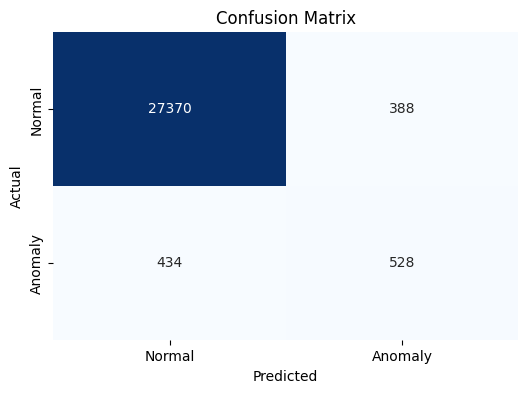

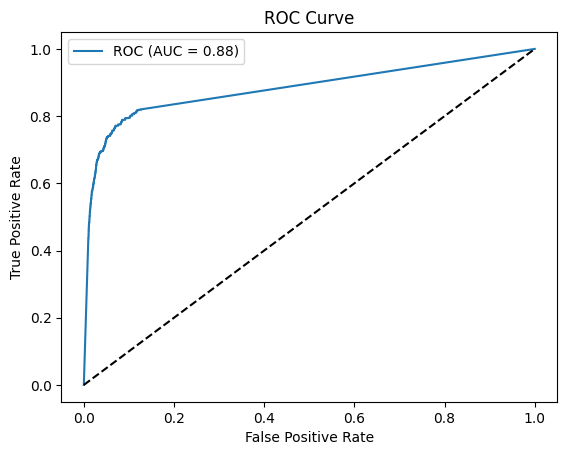


Evaluation Results:
Total samples: 28720
Anomaly rate: 3.35%
Precision: 0.5764
Recall: 0.5489
F1 Score: 0.5623


In [84]:
evaluate_model(model, env)

In [85]:
model.learn(total_timesteps=100000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 287      |
|    ep_rew_mean     | 1.87e+03 |
| time/              |          |
|    fps             | 142      |
|    iterations      | 1        |
|    time_elapsed    | 28       |
|    total_timesteps | 4096     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 283           |
|    ep_rew_mean          | 1.21e+03      |
| time/                   |               |
|    fps                  | 133           |
|    iterations           | 2             |
|    time_elapsed         | 61            |
|    total_timesteps      | 8192          |
| train/                  |               |
|    approx_kl            | 0.00060938287 |
|    clip_fraction        | 9.77e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.04         |
|    explained_variance   | 0.135         |


In [86]:
model.save("ppo_anomaly_detector_xgb_role2_300000steps.zip")

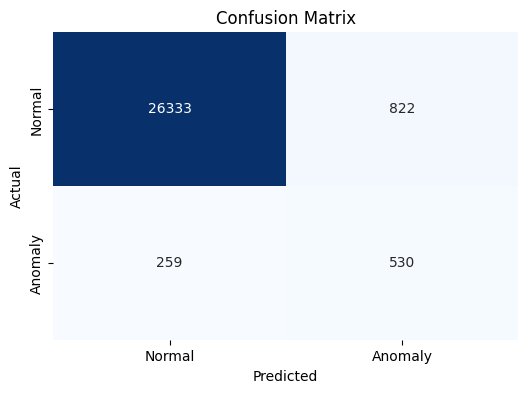

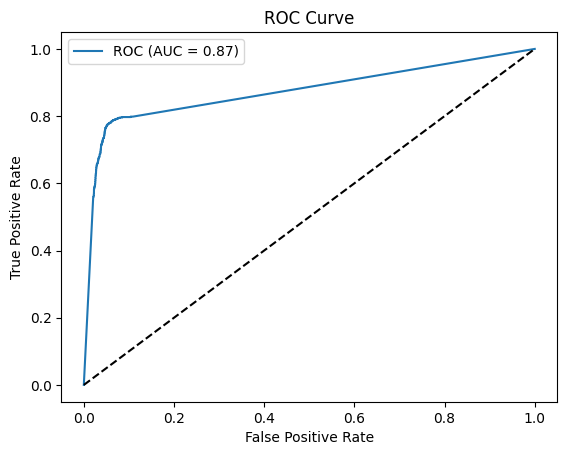


Evaluation Results:
Total samples: 27944
Anomaly rate: 2.82%
Precision: 0.3920
Recall: 0.6717
F1 Score: 0.4951


In [87]:
evaluate_model(model,env)

In [89]:
model.learn(total_timesteps=100000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 235      |
|    ep_rew_mean     | 1.39e+03 |
| time/              |          |
|    fps             | 140      |
|    iterations      | 1        |
|    time_elapsed    | 29       |
|    total_timesteps | 4096     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 271          |
|    ep_rew_mean          | 1.18e+03     |
| time/                   |              |
|    fps                  | 130          |
|    iterations           | 2            |
|    time_elapsed         | 62           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0014150897 |
|    clip_fraction        | 0.00754      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.925       |
|    explained_variance   | 0.151        |
|    learning_r

In [ ]:
model.save("ppo_anomaly_detector_xgb_role2_400000.zip")

In [ ]:
evaluate_model(model,env)